# Decentralized Adaptive Markets

by Kevin McCabe, Aleksander Psurek

Abstract


Introduction

To engage in exchange agents go thorugh a sequence of actions:
* Find Trading Partners
* Negotiate Contract/Agreement
* Fulfill Contract/Agreement
* Reconcile Fulfillment and Build Loyalty

Each of these actions produce transaction costs that reduce the benefits of exchange.  Over time agents try to reduce transaction costs through several mechanisms:
* Centralization (physical and/or virtual)
* Innovation in institutions (rules that shift transaction costs to the institution)
* Innovation in technologies (creating improved virtualization of activities

The goal of our research is to study the dynamics of this process as a evolutionary or adaptive process that buids path dependent institutions to solve the problem of exchange.  In particular we assume that adaptation is largely a gradual process of innovation with what is known, but external shocks sometimes cause more explosive periods of innovation.  As the research progresses w hope to better understand the role of experiments, and field data in validating parts of the model and improving predictive power. 

In this paper we start with a small economy with agents already taking the role of buyers and sellers.  Using market efficeincy as a measure of performance, it is easy to demonstrate that matching costs are the largest costs in our small economy and reducing these costs create strong incentives toward centralization.  As centralization occurs matching costs are replaced by negotiation costs which are reduced by price discovery institutions.     

## Import Modules and Agent Types

In [1]:
# %conda install matplotlib
# %conda install scipy
# %conda install pandas
# %conda instal ffmpeg
# %conda install seaborn
# %conda install scikit-learn
# %conda install conda-forge::moviepy

In [2]:
import random as rnd
import operator
import os
import time
import copy
import sys

# Data processing
import numpy as np                              # import numpy
import pandas as pd
import json

# Plotting
import matplotlib.pyplot as plt                 # import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as tckr

# Custom packages for simulation
# This works only if notebooks folder is in the "modules" parent folder
sys.path.insert(0, '..') # add modules folder (parent folder) into this notebook's path
import institutions.dm_bargain as dm_bargain
import institutions.dm_travel as dm_travel
import environment.dm_agents as dm_agents
import environment.dm_env as env
import dm_utils as dm
import simulations.dm_sim_period as simulate
import dm_process_results as results
import environment.env_make_agents as make_env
#TODO: Change imported name, propagate

# Agent Types

ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
trader_objects = [(ZIDP, 4), (ZIDP, 4)]     


# Enviornment

> **Grid**: **g** = `grid_size` x `grid_size`
> * Agents start out in random locations on the grid
> * Agents can travel (`x + dx`, `y + dy`) in one period
> * Boundaries of grid are hard
> * where dx, dy in {-1, 0, +1}    

> **Time**: Discrete intervals representing specific events.   
> * **week:** w = 0, 1, ... `num_weeks - 1`(Reinitialization of preferences)
     * **period:** p = 0, 1, ..., `num_periods - 1` (Travel one space in grid)
        * **round:** r = 0, 1, ..., `num_rounds - 1` (Make and accept posted-offers)

**Initial Environment**:
* **w = 0**, **p = 0**, **r = 0**, `num_periods` = P, `num_rounds` = R, `num_weeks` = W,
* **g** = `grid_size` x `grid_size`,
* $e^b = (v^b, m^b, u^b, loc^b)$ for b = 0, ..., `num_traders/2`,
* $e^s = (c^s, m^s, \pi^s, loc^s)$ for s = 0, ..., `num_traders/2`.



> **Buyers** (indexed by b) 
* reservation values: $v^b = (v_1, v_2, ..., v_K), m^b$.  
* quantity bought: $q^b$
* prices paid: $p^b = (p_1, ..., p_{q^b})$
* utility:
$$u^b(q^b,p^b) = m^b + \sum_{i=1}^{q^b} v^b_i - \sum_{i = 1}^{q^b} p^b_i$$
* starting position: $e^b = (v^b, m^b, u^b, loc^b)$

> **Sellers** (indexed by s) 
* unit costs: $c^s = (c_1, c_2, ..., c_K), m^s$.  
* quantity sold: $q^s$
* prices received: $p^s = (p_1, ..., p_{q^s})$
* profit:
$$\pi^s(q^s,p^s) = m^s + \sum_{i=1}^{q^s} p^s_i - \sum_{i = 1}^{q^s} c^s_i$$
* starting position: $e^s = (c^s, m^s, \pi^s, loc^s)$

> Notes on values and costs

**Buyer Reservation Values**
```python
values = []
interval = int((self.ub-self.lb)/4
upper = self.ub
lower = self.lb + interval
for unit in range(self.num_units):
    value = np.random.randint(lower, upper+1)
    values.append(value)
return sorted(values, reverse=True)
```
**Seller Unit Costs**
```python
costs = []
interval = int((self.ub-self.lb)/4
upper = self.ub - interval
lower = self.lb
for unit in range(self.num_units):
    cost = np.random.randint(lower, upper+1)
    costs.append(cost)
return sorted(costs, reverse=False)
```

## Build environment

In [3]:
grid_size = 1     # Grid is grid_size x grid_size
num_traders = 8   # traders (multiple of two) 
num_units = 6     # Number of units per trader
lower_bound = 200 # lower bound on values or costs
upper_bound = 600 # upper bound on values or costs
debug = False

agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
#agent_maker.make_test_agents()
agent_maker.make_agents()
agent_maker.make_locations()
agents = agent_maker.get_agents()
agent_maker.print_agents(agents)


B_1_ZIDP   BUYER  @(0, 0):[  504,  501,  445,  442,  433,  396]cu = 0
B_2_ZIDP   BUYER  @(0, 0):[  593,  593,  591,  549,  462,  447]cu = 0
B_3_ZIDP   BUYER  @(0, 0):[  588,  551,  492,  469,  438,  354]cu = 0
B_4_ZIDP   BUYER  @(0, 0):[  594,  587,  584,  468,  404,  364]cu = 0
S_1_ZIDP   SELLER @(0, 0):[  202,  209,  288,  428,  440,  472]cu = 0
S_2_ZIDP   SELLER @(0, 0):[  204,  222,  224,  287,  333,  348]cu = 0
S_3_ZIDP   SELLER @(0, 0):[  269,  285,  297,  358,  427,  485]cu = 0
S_4_ZIDP   SELLER @(0, 0):[  279,  358,  431,  447,  495,  499]cu = 0


## Present Environment as Supply and Demand

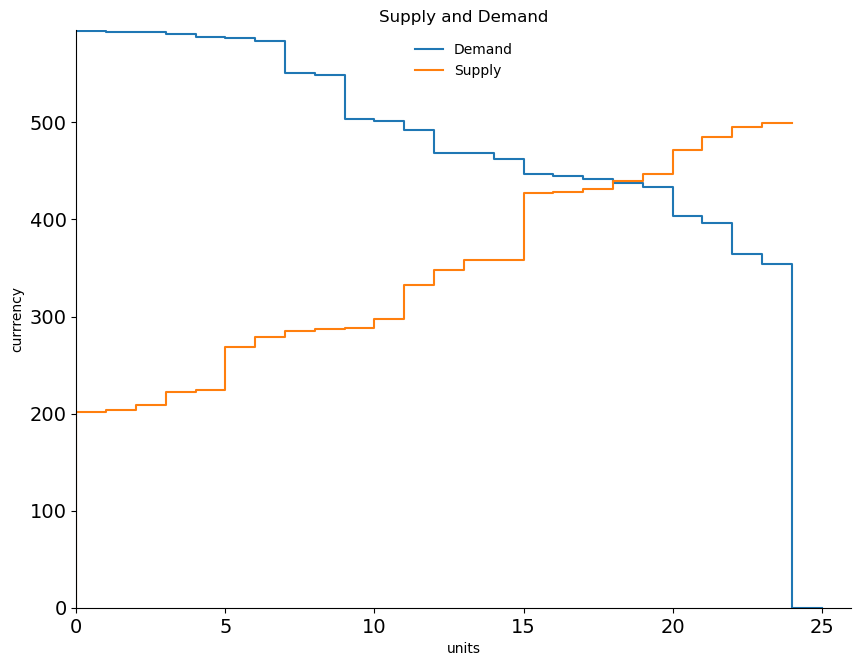

In [4]:
# set up market
agent_maker.make_market("test_market")
agent_maker.plot_market()
market = agent_maker.get_market()

## Show Equilibrium Calculations

In [5]:
agent_maker.show_equilibrium()


When market test_market is in equilibrium we have:
equilibrium price    = 438 - 440
equilibrium quantity = 18
maximum surplus      = 4011



# Institutions

>text file for https://bramp.github.io/js-sequence-diagrams/
```
Environment -> Simulator: Init Agents
Simulator -> Travel: Init Travel
Simulator -> Bargain: Init Bargain
Simulator -> Travel: Start Move
Travel -> Agents: Move
Agents -> Travel: (x, y)
Travel -> Simulator: End, Grid
Simulator -> Bargain: Start Bargain
Bargain -> Agents: Offers
Agents -> Travel: [Bid, ASK, or NULL]
Bargain -> Agents: Transact
Agents -> Travel: [Buy, Sell, or NULL]
Bargain -> Simulator: End, Contracts
```

### Sequence Diagram
![Sequence Diagram](../assets/sequence_diagram.svg)

## Messages Table

|Directive  |Sender   |Receiver   |Payload    |Expected Action by Receiver|
| :-------: | :-----: | :-------: | :-------: | :------------: |
|INIT_A     |Env      |Agent(s)   |$e^b$      |Make Agent|
|INIT_T     |Env      |Travel     |grid, agents |Make Grid|
|INIT_B     |Env      |Bargain    |upper, lower, num_rounds |Make Bargain|
|START_S    |Env      |Sim        |num_periods|Start period_walk through periods$^1$, in period_walk send START_M to Travel| 
|START_M    |Sim      |Travel     |period     |Start agent_walk through fixed agent_order$^2$, Send MOVE to Agent in walk|
|MOVE       |Travel   |Agent(s)   |period, g  |Decide (dx, dy), Send MOVE_D|
|MOVE_D     |Agent    |Travel     |(dx, dy)   |Validate, Update g, continue agent_walk, at endsend END_M to sim|
|END_M      |Travel   |Sim        |g          |Start grid_walk thrugh g, when match found send START_B to Bargain|
|START_B    |Sim      |Bargain    |agents at point in g| Randomize agent order, start agent_walk through rounds|  Send OFFER to Agent in walk|
|OFFER      |Bargain  |Agent(s)   |Order Book |Decide Bid or Ask, send BID/ASk/NULL to Bargain| 
|Bid        |Agent    |Bargain    |Bid        |Validate, Update Order_Book, Send OFFER to Next agent, START_T after all offers|
|ASK        |Agent    |Bargain    |Ask        |Validate, Update Order_Book, Send OFFER to Next agent, START_T after all offers|
|NULL       |Agent    |Bargain    |None       |Do Nothing, Send OFFER to Next agent, START_T after all offers|
|START_T    |Bargain  |Bargain    |None       |Validate, Randomize Agent Order, snd TRANSACT to first agent| 
|TRANSACT   |Bargain  |Agent      |Order_Book |Decide BUY or SELL, send BUY/SELL/NULL to Bargain, Send TRANSACT to next Agent| 
|BUY        |Agent    |Bargain    |Order to buy from| Validate, Make Contract, send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
|SELL       |Agent    |Bargain    |Order to sell to|  Validate, Make Contract, send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
|NULL       |Agent    |Bargain    |None       |send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
* We are done when all walks are completed





## Messages

```python
class Message(object):
    """Messages will be passed as objects
    """
    def __init__(self, directive, sender, receiver, payload):
        """
           directive = string to deetermine call
           sender = sender name
           receiver = receiver name
           payload = payload
        """
        self.directive = directive
        self.sender = sender
        self.receiver = receiver
        self.payload = payload
        
    def get_directive(self):
        return self.directive
    
    def get_sender(self):
        return self.sender
    
    def get_receiver(self):
        return self.receiver
    
    def get_payload(self):
        return self.payload
    
    def unpack(self):
        directive = self.directive
        sender = self.sender
        receiver = self.receiver
        payload = self.payload
        return (directive, sender, receiver, payload)
    
    def print_message(self):
        d = self.get_directive()
        print(f"directive = {d}")
        print(f"sender = {self.get_sender()}")
        print(f"receiver = {self.get_receiver()}")
        print(f"payload = {self.get_payload()}")
```

## Message Flow

* **period_loop** `<- START S` (`determines search length`) 
    * **travel_loop** `<- START M`through agents (`updates grid`)
        * MOVE -> MOVE_D
    * **grid_loop** `<- START G`through grid_points (`looking for bargaining opportunities`)
        * if Buyer-Seller Match:  
        * **round_loop** `<- START_B` (`determines bargaining rounds for a given period`) 
            * **offer_loop** `<- START_O` through agents in agent_order (`gets all offers`)
                * OFFER -> BID, ASK, NULL
            * **transact_loop**  `<- START_T` through agents in random_order (`gets all acceptance decisions`)
                * TRANSACT -> BUY, SELL, NULL
                    

```python
sim_period_runner:
    ...
    travel_institution:
        loop through agents:
            request move
            if valid move -> make move
    loop through points in grid:
        if at least one buyer and seller at point:
            bargain_institution:
                loop through rounds:
                    loop through agents:
                        request "BID, ASK" 
                        if valid -> put in order_book
                    loop through agents in random-order:
                        request "BUY, SELL"
                        if valid -> make contract
```

# Trader Strategies

## ZID

> Travel
```Python
    def move_requested(self, pl):
        """
        Make a move in a random direction if you can still trade 
        """
        direction_list = [-1, 0, +1] # 
        if self.cur_unit > self.max_units:
            return_msg = Message("MOVE", self.name, "Travel", (0, 0))
            self.returned_msg(return_msg)
            return return_msg 
        else:
            x_dir = rnd.choice(direction_list)
            y_dir = rnd.choice(direction_list)
            return_msg = Message("MOVE", self.name, "Travel", (x_dir, y_dir))
            self.returned_msg(return_msg)
            return return_msg 
```

> Offer
```Python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            WTP = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            return_msg = Message("BID", self.name, "BARGAIN", WTP)
            self.returned_msg(return_msg)
            return return_msg   

        else: # for SELLER
            WTA = rnd.randint(self.costs[self.cur_unit], self.upper_bound)
            return_msg = Message("ASK", self.name, "BARGAIN", WTA)
            self.returned_msg(return_msg)
            return return_msg  
```

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            WTP = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            for trader_id in current_offers:
                if current_offers[trader_id] == None:
                    continue
                offer_type = current_offers[trader_id][0]
                offer_amount = current_offers[trader_id][1]
                if offer_type == "ASK":
                    offers.append((trader_id, offer_amount))
            # Make a random choice from offers and try to transact    
            if len(offers) > 0:
                offer = rnd.choice(offers)
                if WTP >= offer[1]:  # offer[1] = sellers willingness to accept
                    seller_id = offer[0]
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            else:
                return_msg = Message("NULL", self.name, "BARGAIN", None)
                self.returned_msg(return_msg)
                return return_msg
 ```           

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            wtp = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            ...
            # Make a random choice from offers and try to transact    
            ...
                seller_id, ask = rnd.choice(offers)
                if wtp >= ask: 
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            ...
```          

## Sample Simulation

In [6]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:<4}-{price:4} -{s_cos:>4}:{s_cur:<3}    {buyer:10} {seller:10}")

sim_name = "Sample One Period Simulation"
num_rounds = 10
num_periods = 1
plot_on = False
debug = False

sim_agents = copy.deepcopy(agents)
contracts = []
sim1 = simulate.SimPeriod(sim_name, num_rounds, sim_agents, 
                market, grid_size, debug, plot_on)
for period in range(num_periods):
    sim1.run_period()
    contracts.extend(sim1.get_contracts())

print()
contracts = sim1.get_contracts()
print_contracts(contracts)



CONTRACTS:
rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id
-------------------------------------------------------
 0   0:593 - 543 - 204:0      B_2_ZIDP   S_2_ZIDP  
 0   0:588 - 329 - 202:0      B_3_ZIDP   S_1_ZIDP  
 1   0:594 - 539 - 222:1      B_4_ZIDP   S_2_ZIDP  
 1   1:587 - 292 - 209:1      B_4_ZIDP   S_1_ZIDP  
 1   0:504 - 502 - 288:2      B_1_ZIDP   S_1_ZIDP  
 1   1:593 - 322 - 279:0      B_2_ZIDP   S_4_ZIDP  
 2   1:551 - 518 - 269:0      B_3_ZIDP   S_3_ZIDP  
 2   2:591 - 467 - 224:2      B_2_ZIDP   S_2_ZIDP  
 3   2:492 - 293 - 287:3      B_3_ZIDP   S_2_ZIDP  
 3   1:501 - 358 - 358:1      B_1_ZIDP   S_4_ZIDP  
 4   2:445 - 360 - 285:1      B_1_ZIDP   S_3_ZIDP  
 5   2:584 - 530 - 297:2      B_4_ZIDP   S_3_ZIDP  
 5   3:469 - 431 - 333:4      B_3_ZIDP   S_2_ZIDP  
 7   3:549 - 383 - 358:3      B_2_ZIDP   S_3_ZIDP  
 7   3:468 - 416 - 348:5      B_4_ZIDP   S_2_ZIDP  


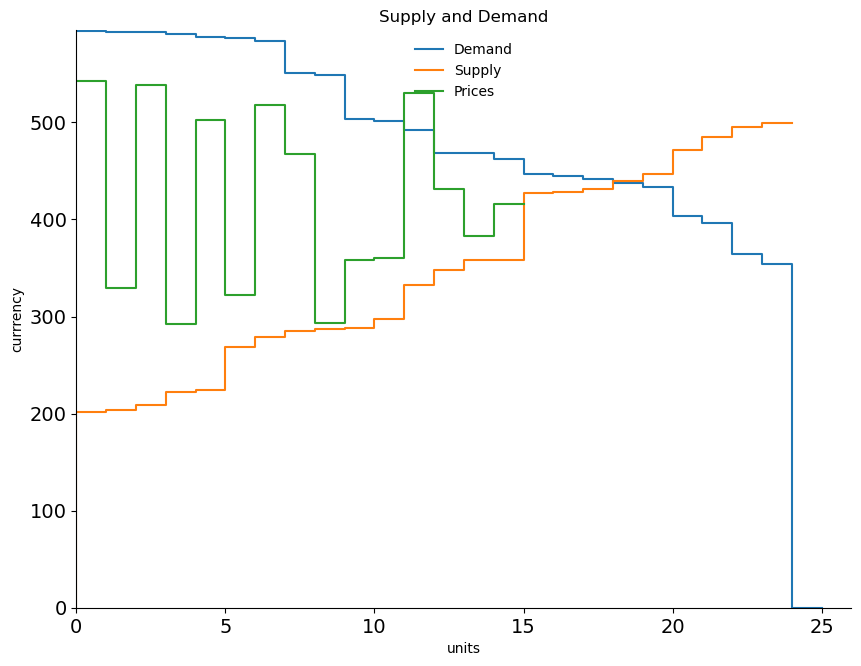

In [7]:
pr_1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
pr_1.plot_prices()

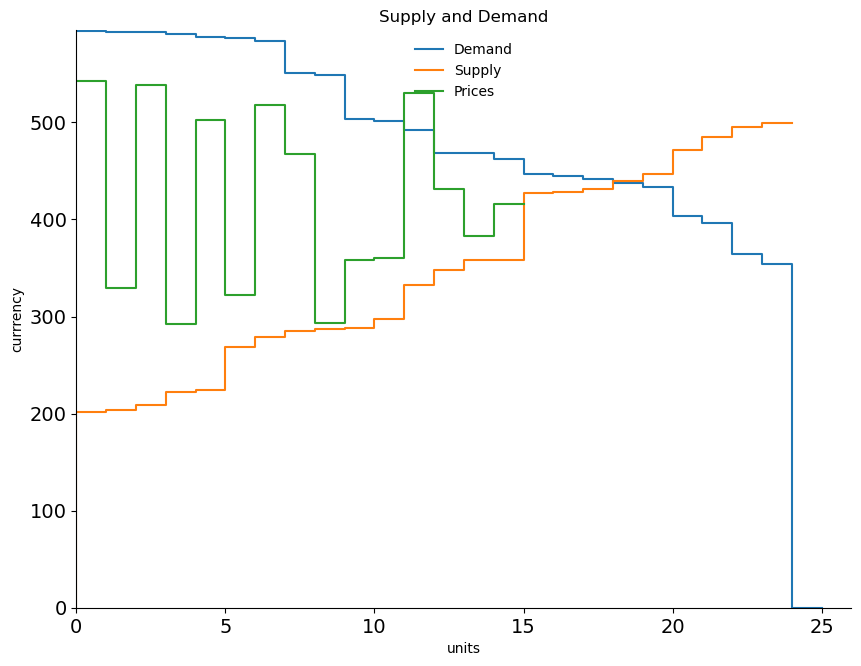

In [8]:
fig = pr_1.plot_prices()

# Performance


In [9]:
pr_1.get_results()
pr_1.display_results()


      equilibrium price range is 438 to 440
      average price = 418.8666666666667
      equilibrium expected contracts = 18, actual contracts = 15
      buyer surplus = 1826, seller surplus = 2120
      actual_surplus = 3946, maximum surplus = 4011
      efficiency = 98.38%.



# Simulation Runner

## Simulation_Sequence Markup

>text file for https://bramp.github.io/js-sequence-diagrams/
```
Simulator -> Session: Control Variables
Note right of Simulator: folder\nnum_traders\nnum_units\ngrid_size\nnum_weeks\nnum_periods\nnum_rounds\nnum_trials
Session -> Week: Session Variables
Note right of Session:Loop through\ntrials
Note right of Session:sub_folder\ncontrol vars\ntrial_num\ntreatment vars:\n..starting grid\n..preferences
Week -> Period: Period Variables
Note right of Week: week_num\nold grid\nValues/Costs
Period -> Agents: Init Incentives
Note right of Period: Loop through\nperiods in week
Note right of Period: period_num\ncur_unit = 0\ntravel_info\nprice_info
Period -> Travel: old grid
Travel -> Agents: Make Move
Note right of Travel: Loop through \nagents
Agents -> Travel: Move
Note right of Agents:(dx, dy)
Travel -> Period: data from travel
Note right of Travel: data:\nnew_grid\nmove history
Period -> Matching: Find_Trades
Note right of Period: Initiates search\nof new grid for\nbuyer/seller matches
Matching -> Bargain: Agent List
Note right of Matching: agents at gird location\nnum_rounds
Note right of Bargain: loop thorugh rounds
Bargain -> Agents: Make Offer
Note right of Bargain:Loop through\nagents
Agents -> Bargain: Offer
Bargain -> Agents: Make Trade
Note right of Bargain:Loop through\nagents
Agents -> Bargain: Trade
Bargain -> Period: data from bargain
Note right of Bargain:offer/trade history\ncontract:\nprice\nbuyer_id\nseller_id\nbuyer_unit\nbuyer_value\nseller_unit\nseller_cost
Period -> Week: data from period
Note right of Period: Data:\ntravel history\nbargain history\ncontracts
Week -> Session: data from week
Session -> Simulator: data from session
```

## Simulation Sequence Diagram

![Simulation Diagram](../assets/simulation_diagram.svg)

## Pseudo Code for Simulation Runs 
```
Simulator:
    Get Simulator Variables: sim_name
        Make main folder: sim_name + date
    Get Control Variables
        Write variables to main folder
    Get treat_key = treatment_name, treatment_list 
    Loop through treatments (using treatment as index) 
        Loop num_trials times (using trial as index)
            Make agents (set preferences and locations)
            Loop num_weeks times (using week as index)
                Init agents (preferences and locations)
                Loop num_period times (using period as index)
                    Loop through agents (using agent as index)
                        agent makes travel decisions (upgrades grid location)
                    Loop through grid (using loc as index)
                        If there is a Buyer and Seller at loc:
                            Loop num_round times (using round as location)
                            Loop through agents@loc (using agent as index)
                                agent makes offer (Bid or Ask) in order_book
                            Loop through agents@loc in random order (using agent as index)
                                agent makes Buy or Sell decision to offer in order_book
                    Record period_data
                Record week_data
            Record session_data
        Record trial_data
       

## Folder Structure
```
dm_simulations/
    'sim_name + date'/
       'sim_name'.config
       'treatments'/
           'treatments'.config
           'treatment_id'/
               'treatment_id'.config
               'trials'/
                   'trial###'/
                       datum['id'][week][period][round]       
```

# Simulations

## Runner with treatment lists

In [1]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:4} -{price:4}-{s_cos:4}{s_cur:3}    {buyer:10} {seller:10}")

def print_locations(agents):
    for agent in agents:
        print(f"agent {agent.name} is at location {str(agent.get_location())}")

def chk(x, index):
    """
    Checks is x is an integer or list, if a list, returns the integer at the index position
    TODO: Review why this exists?
    """
    typ = type(x)
    assert typ == int or typ == list, "bad type"
    if type(x) == int:
        return x
    elif type(x) == list:
        return x[index]
        
def make_simulation(controls, treat_key, trader_objects, period_verbose=False, debug=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        period_verbose: boolean (optional) - define if the simulation should save and return each 
            period's results
        trader_object: list of ["Trader Type Name", NumTradersOfType] - defines the traders to be used in the simulation
    """
    treat_number = 0
    num_weeks = chk(controls['num_weeks'], treat_number)
    num_periods = chk(controls['num_periods'], treat_number)
    num_rounds = chk(controls['num_rounds'], treat_number)
    grid_size = chk(controls['grid_size'], treat_number)
    num_traders = chk(controls['num_traders'], treat_number)
    num_units = chk(controls['num_units'], treat_number)
    lower_bound = chk(controls['lower_bound'], treat_number)
    upper_bound = chk(controls['upper_bound'], treat_number)
    num_trials = chk(controls['num_trials'], treat_number)

    # Setup data tsructure for effs
    effs = []
    for k, treat in enumerate(controls[treat_key]):
        subeffs = []
        for trial in range(num_trials):
            subeffs.append(0)
        effs.append(subeffs)

    ## TODO CONTINUE
    if period_verbose:
        sim_columns = ['num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound', 'treat', 'trial', 'period', 
                               'period_contracts', 'period_locs']
        sim_data = []

    print('Started Simulation')
    for trial in range(num_trials):
        for index, treat in enumerate(controls[treat_key]):
            
            # collect controls
            num_periods = chk(controls['num_periods'], index)
            num_rounds = chk(controls['num_rounds'], index)
            grid_size = chk(controls['grid_size'], index)
            num_traders = chk(controls['num_traders'], index)
            num_units = chk(controls['num_units'], index)
            lower_bound = chk(controls['lower_bound'], index)
            upper_bound = chk(controls['upper_bound'], index)
            
            # make agents
            agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                        grid_size, lower_bound, upper_bound, debug)
            agent_maker.make_agents()
            agent_maker.set_locations(grid_size)
            agents = agent_maker.get_agents()

            # set up market
            agent_maker.make_market("test_market")
            market = agent_maker.get_market()
            
            # run sim
            contracts = []

            sim_agents = copy.deepcopy(agents)  # reinitialize
            sim1 = simulate.SimPeriod(sim_name, num_rounds, sim_agents, 
                   market, grid_size, debug, plot_on)
            
            for period in range(num_periods):
                sim1.run_period()
                contracts.extend(sim1.get_contracts())

                # Save the effects of this period on the simuation - movement and contracts
                if period_verbose:

                    # Save starting positions for the simulation at period = -1
                    if period == 0:
                        init_locs = copy.deepcopy(sim1.get_initial_grid())
                        init_data = [num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, treat, trial, -1, 
                                       [], init_locs]
                        sim_data.append(init_data)
                    
                    period_contracts = copy.deepcopy(sim1.get_contracts())
                    period_locs = copy.deepcopy(sim1.get_grid())
                    period_data = [num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, treat, trial, period, 
                                   period_contracts, period_locs]
                    sim_data.append(period_data)
            
            # process results
            pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
            pr1.get_results()
            effs[index][trial] = pr1.get_efficiency()
    print('Finished Simulation')

    if period_verbose:
        df_verbose = pd.DataFrame(data=sim_data, columns=sim_columns)
        return effs, df_verbose, sim1
    
    return effs



In [11]:
# Allows multiple weeks (prev above does not - later weeks one does not follow the same format or allow for multiple trials)
# Only returns dataframes
def make_simulation_wide(controls, trader_objects, debug=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        controls: dictionary of controls for the simulation
        trader_object: list of ["Trader Type Name", NumTradersOfType] - defines the traders to be used in the simulation
        debug: boolean (optional): should the function print deep debug information
        Note: Dropped the treat_key idea - this should be done on the outside and the function should be called with the controls as a set thing
    """
    treat_number = 0
    num_trials = chk(controls['num_trials'], treat_number) # For monte carlo
    num_weeks = chk(controls['num_weeks'], treat_number) # Contain periods
    num_periods = chk(controls['num_periods'], treat_number) # Number of movement periods
    num_rounds = chk(controls['num_rounds'], treat_number) # number of trading rounds after movement
    grid_size = chk(controls['grid_size'], treat_number) # size of the grid nXn
    num_traders = chk(controls['num_traders'], treat_number) # number of traders - checks against the trader objects 
    num_units = chk(controls['num_units'], treat_number) # number of units each (selling) trader has or buying trader wants (? not sure abou this second half)
    lower_bound = chk(controls['lower_bound'], treat_number) # Minimum valuation of units
    upper_bound = chk(controls['upper_bound'], treat_number) # Maximum valuation of units

    sim_columns = ['num_trials', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound', 
                    'trial', 'week', 'period', 'efficiency', 'type_effs', 'period_contracts', 'period_locs']
    sim_data = []
    
    print('Started Simulation')
    for trial in range(num_trials):

        # make agents
        agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, grid_size, lower_bound, upper_bound, debug)
        agent_maker.make_agents()
        agent_maker.set_locations(grid_size)
        agents = agent_maker.get_agents()

        # set up market
        agent_maker.make_market("test_market")
        market = agent_maker.get_market()
        
        # run sim
        contracts = []
        
        for week in range(num_weeks):
            for agent in agents:
                agent.start(None)
            contracts = []
            sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
                   market, grid_size, debug, plot_on)
            for period in range(num_periods):
                sim1.run_period()
                contracts.extend(sim1.get_contracts())

                # Save starting positions for the simulation at week and period = -1
                if week==0 and period == 0:
                    init_locs = copy.deepcopy(sim1.get_initial_grid())
                    init_data = [num_trials, num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, 
                                 trial, -1, -1, None, [], [], init_locs]
                    sim_data.append(init_data)

                # process results
                pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
                pr1.get_results()
                efficiency = pr1.get_efficiency()

                type_eff = pr1.get_type_surplus()
                
                period_contracts = copy.deepcopy(sim1.get_contracts())
                period_locs = copy.deepcopy(sim1.get_grid())
                
                period_data = [num_trials, num_weeks, num_periods, num_rounds, grid_size, num_traders, num_units, lower_bound, upper_bound, 
                               trial, week, period, efficiency, type_eff, period_contracts, period_locs]
                sim_data.append(period_data)


    print('Finished Simulation')

    
    df_verbose = pd.DataFrame(data=sim_data, columns=sim_columns)
    return df_verbose, sim1

## Increase bargaining rounds

### Initialize and run

In [12]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 1,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_1 = make_simulation(controls, key, trader_objects)


Started Simulation
Finished Simulation


In [93]:
len(data_table_1[0])

500

### Graph Efficiences

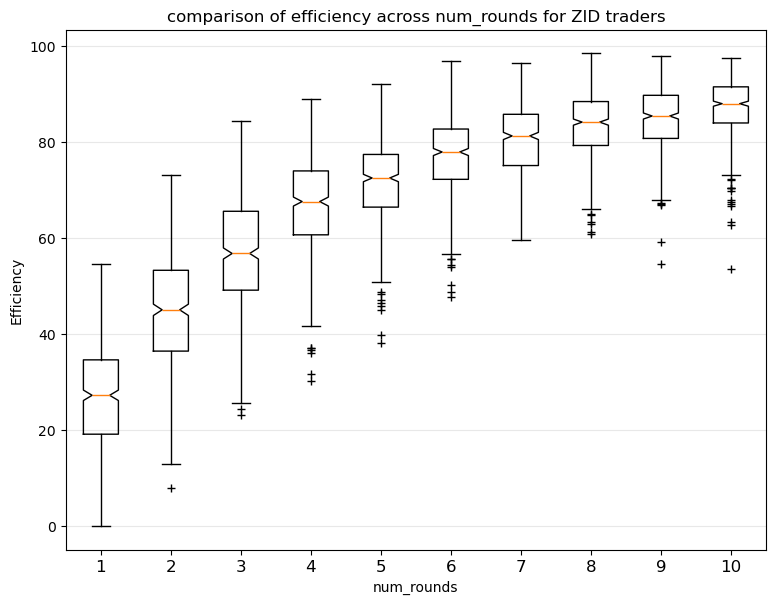

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_1, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

As we increase the number of bargaining rounds in a 1x1 grid the ZID agents have opportunities to make more rounds of offers. This increases the opportunity for trades and thus increases the gains from exchange.  

## Increase grid_size

### initialize and run

In [14]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': 10,
    'grid_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'grid_size'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_2 = make_simulation(controls, key, trader_objects)


Started Simulation
Finished Simulation


### Graph efficiencies

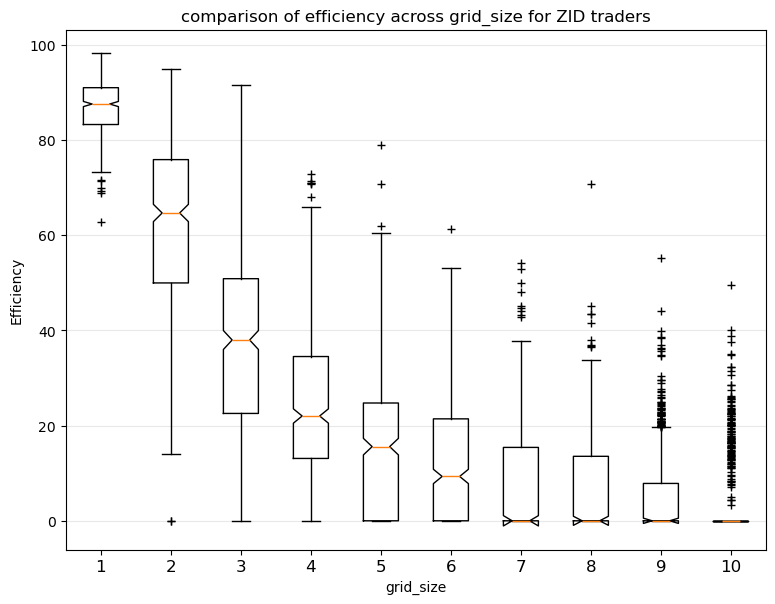

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_2, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

## Increase Search Periods for Agents 

### Initialize and run

In [16]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 10,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_3 = make_simulation(controls, key, trader_objects)


Started Simulation
Finished Simulation


### Graph Efficiencies

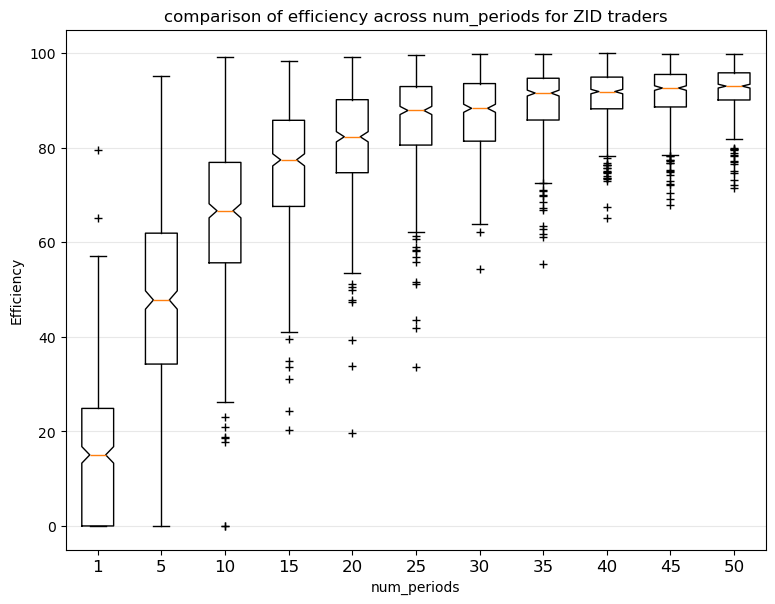

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_3, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

##  Round Effect (using Two tables)

### Initialize and Run

In [18]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 1,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_4 = make_simulation(controls, key, trader_objects)
# for k in data_table_4:
#    print(k)

Started Simulation
Finished Simulation


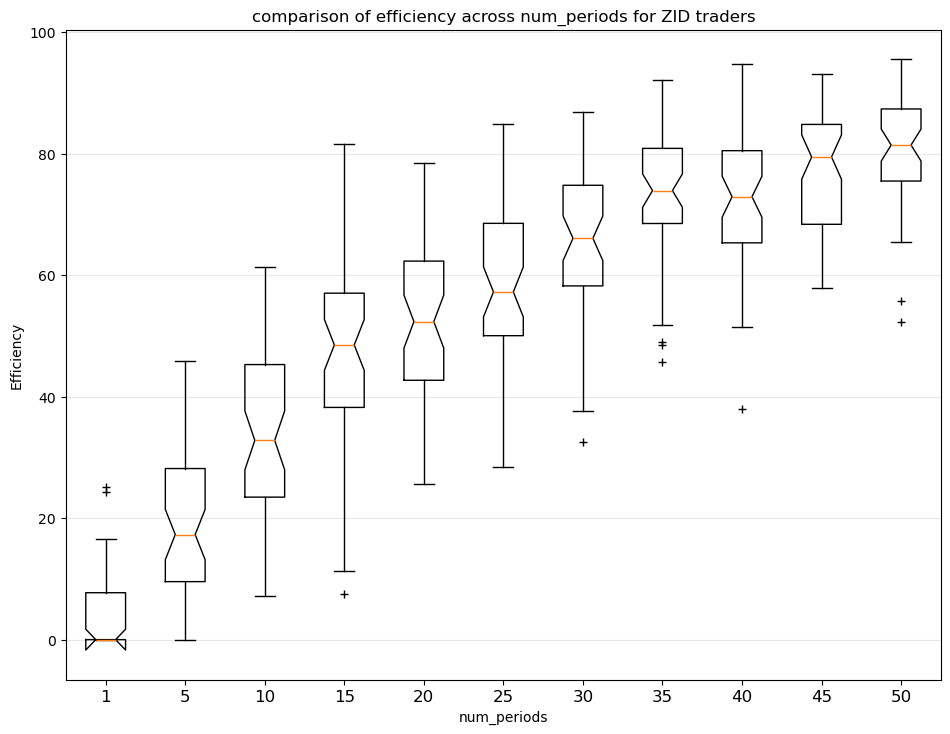

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_4, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Graph Efficiencies

In [20]:
whole_table = []
# Rearrange data in tables
for k in range(len(data_table_3)):
    whole_table.append(data_table_3[k])
    whole_table.append(data_table_4[k])
treatments = []
for k in controls['num_periods']:
    treatments.append(k)
    treatments.append(k)
print(treatments)
    


[1, 1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 35, 35, 40, 40, 45, 45, 50, 50]


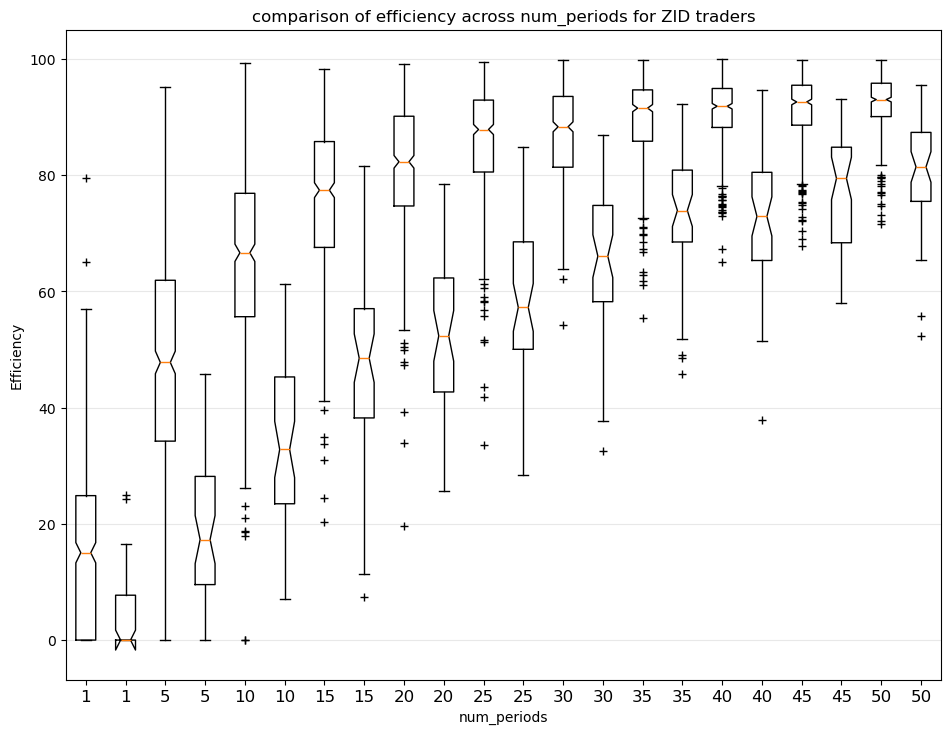

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(whole_table, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(treatments, fontsize=12)

plt.show()

### Narrative

## Round effect for Grid Size 10 and 50 periods

### Init and run

In [22]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 30,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 5,
    'num_traders': 20,
    'num_units': 10,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_5 = make_simulation(controls, key, trader_objects)

Started Simulation
Finished Simulation


### Graph Efficiencies

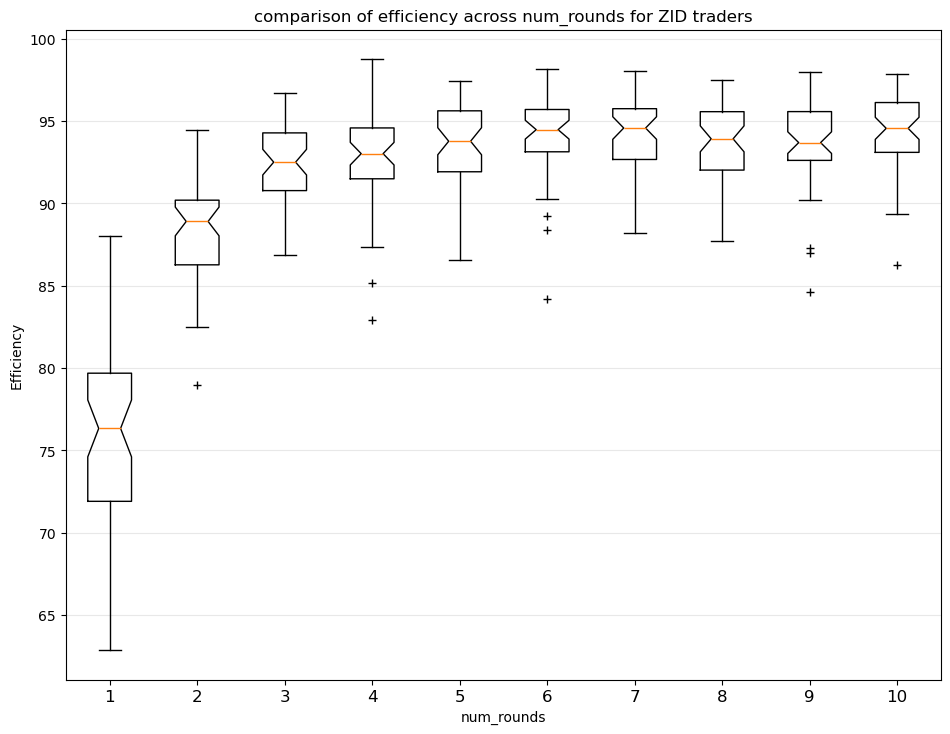

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_5, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

# Runner for comparing efficiencies between strategies 

```python
generate agent preferences
sim_weekly_runner:
    reset agent preferences
    loop through periods
        sim_period_runner:
        ...
            travel_institution:
                loop through agents:
                    request move
                    if valid move -> make move
            loop through points in grid:
            if at least one buyer and seller at point:
                bargain_institution:
                    loop through rounds:
                        loop through agents:
                            request "BID, ASK" 
                            if valid -> put in order_book
                        loop through agents in random-order:
                            request "BUY, SELL"
                            if valid -> make contract
```

In [24]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation_1(controls_1, trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """
    
    num_weeks = controls_1['num_weeks']
    num_periods = controls_1['num_periods']
    num_rounds = controls_1['num_rounds']
    grid_size = controls_1['grid_size']
    num_traders = controls_1['num_traders']
    num_units = controls_1['num_units']
    lower_bound = controls_1['lower_bound']
    upper_bound = controls_1['upper_bound']

    effs = []
    locs = []
    
    
    # make agents
    agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
    
    return effs, locs



## Test ZID

In [25]:
ZID = dm_agents.ZID     # name of agent class that moves randomly and accepts random offers
trader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same

controls_1 = {
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}

data_table_6, locs = make_simulation_1(controls_1, trader_objects)

for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)

## Test ZIDA

In [26]:
ZIDA = dm_agents.ZIDA   # name of agent class that stays at past-trasacted point
trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

data_table_7, locs = make_simulation_1(controls_1, trader_objects)
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)

## Compare ZID and ZIDA efficiencies grid_size = 10

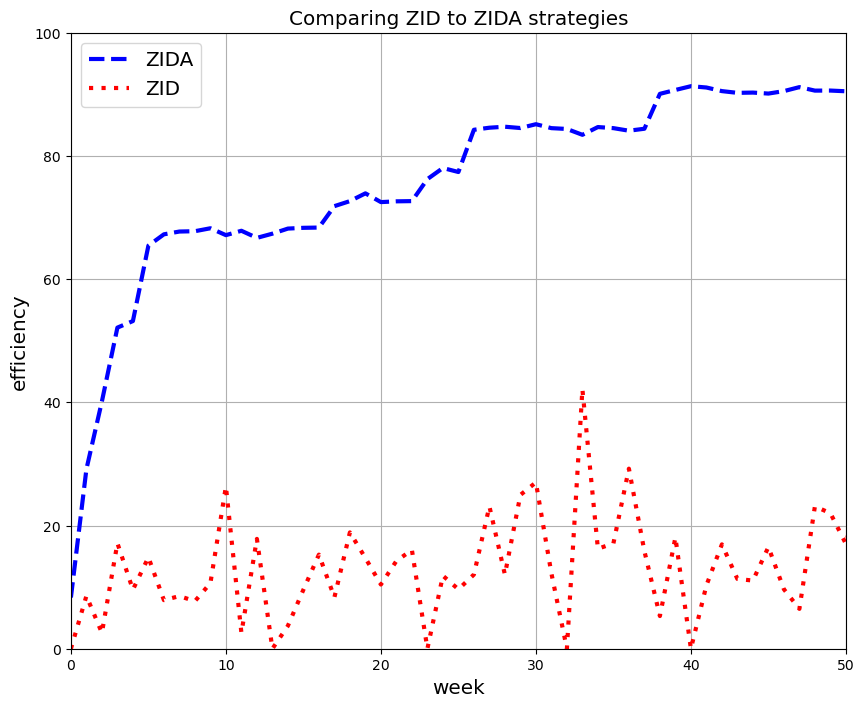

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dashed', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 50)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPA

In [28]:
ZIDPA = dm_agents.ZIDPA # Class of Agent that stay at past-transacted point and accepts best offer

trader_objects = [(ZIDPA, 10), (ZIDPA, 10)]     # List of artificial traders, length 2, can be same

data_table_8, locs = make_simulation_1(controls_1, trader_objects)
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)

## Compare ZID, ZIDA, and ZIDPA efficiencies grid_size = 10

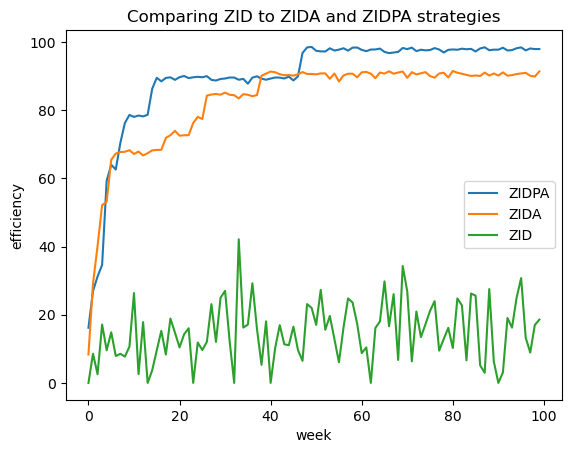

In [29]:
fig, ax = plt.subplots()
ax.plot(data_table_8, label = 'ZIDPA')
ax.plot(data_table_7, label = 'ZIDA')
ax.plot(data_table_6, label = 'ZID')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing ZID to ZIDA and ZIDPA strategies')
ax.legend()

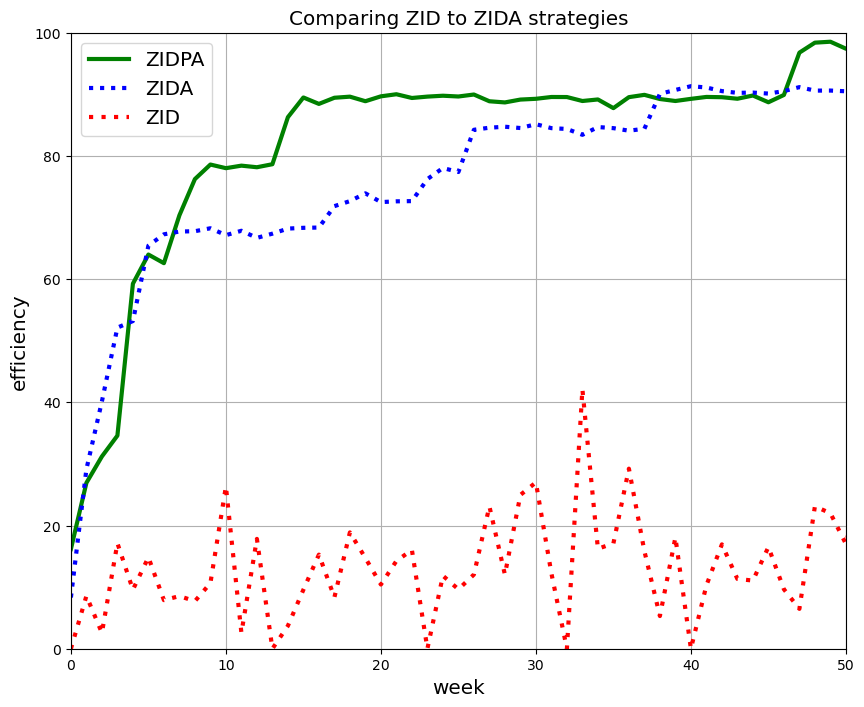

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dotted', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 50)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPR

In [31]:
ZIDPR = dm_agents.ZIDPR # Class of Agent that stay at past-transacted point, unless that point is too congested, and accepts best offer
trader_objects = [(ZIDPR,10), (ZIDPR,10)]     # List of artificial traders, length 2, can be same
data_table_9, locs = make_simulation_1(controls_1, trader_objects)
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)

## Compare ZID, ZIDA,  ZIDPA and ZIDPR efficiencies grid_size = 10

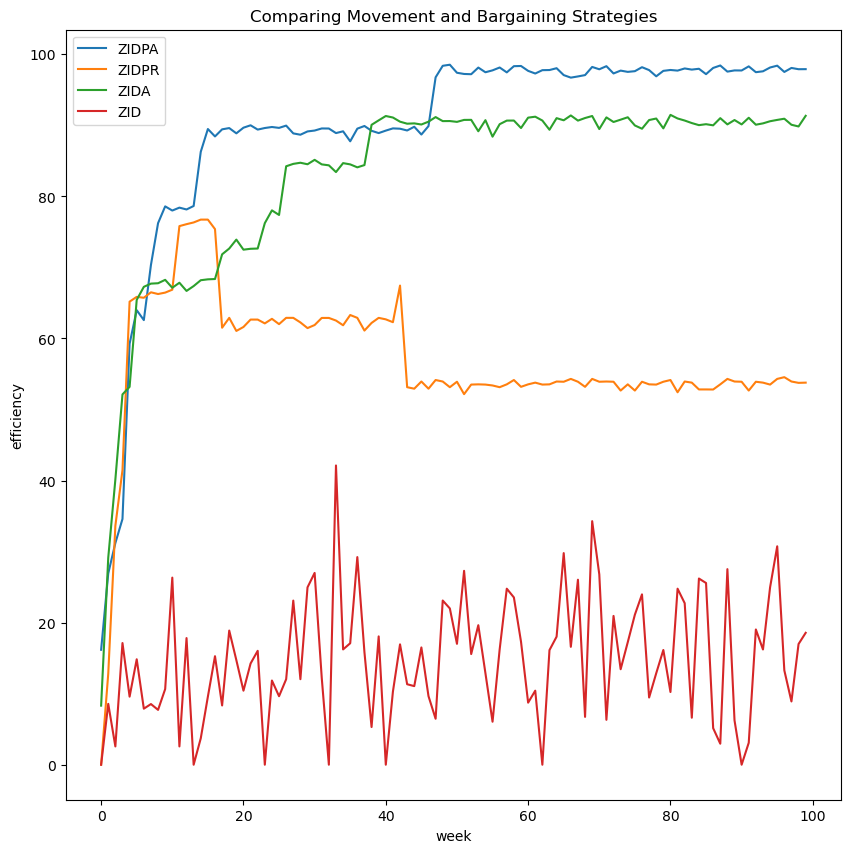

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(data_table_8, label = 'ZIDPA')
ax.plot(data_table_9, label = 'ZIDPR')
ax.plot(data_table_7, label = 'ZIDA')
ax.plot(data_table_6, label = 'ZID')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing Movement and Bargaining Strategies')
ax.legend()

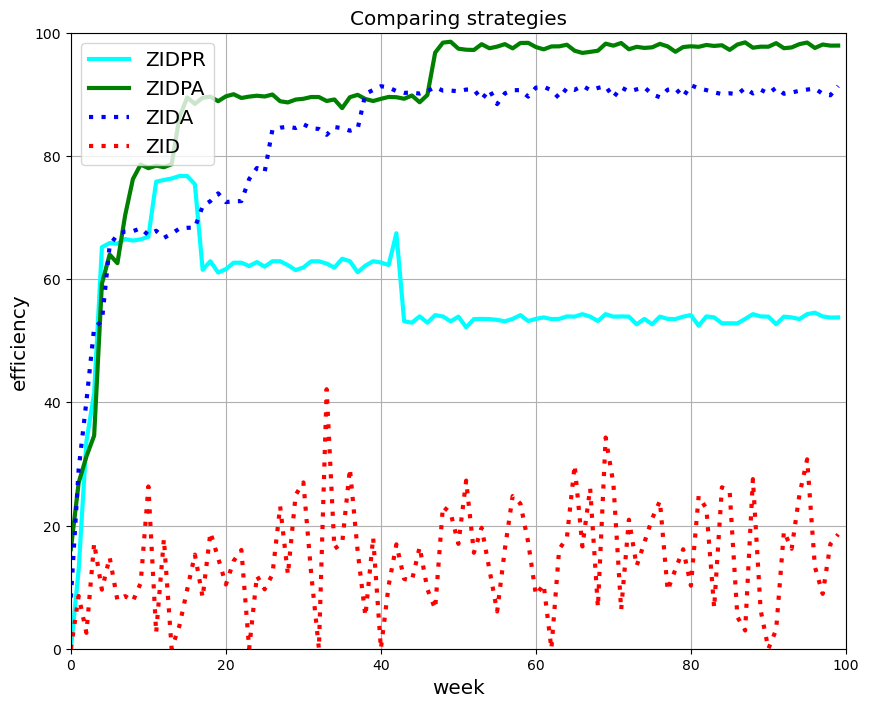

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_9, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 100)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing strategies', size = 'x-large')
ax.legend(fontsize='x-large')

# Compare agent strategies/types competing within periods

## Runner for running weeks

In [34]:
def make_simulation_2(controls_2, trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 
    
    num_weeks = controls_2['num_weeks']
    num_periods = controls_2['num_periods']
    num_rounds = controls_2['num_rounds']
    grid_size = controls_2['grid_size']
    num_traders = controls_2['num_traders']
    num_units = controls_2['num_units']
    lower_bound = controls_2['lower_bound']
    upper_bound = controls_2['upper_bound']

    effs = []
    type_effs = []
    locs = []
    
    
    # make agents
    agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
        type_eff = pr1.get_type_surplus()
        type_effs.append(type_eff)  
    return effs, type_effs, locs



### Initialize and run ZID vs ZIDP

In [35]:
ZID = dm_agents.ZID     # name of agent class that makes random moves, accepts random offers
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZIDP, 10)]     # List of artificial traders, length 2, can be same 

controls_2 = {
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 1,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}

data_table_10, data_table_11, locs = make_simulation_2(controls_2, trader_objects)

ZID_surplus = []
ZIDP_surplus = []
for type_surplus in data_table_11:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDP' in type_surplus:
        ZIDP_surplus.append(type_surplus['ZIDP'])
    else:
        ZIDP_surplus.append(0)   

data_table_12 = [ZID_surplus, ZIDP_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

'\nfor loc in locs:\n    loc_d = {}\n    for g_loc in loc:\n        if g_loc in loc_d.keys():\n            loc_d[g_loc] += 1\n        else:\n            loc_d[g_loc] = 1\n    print(len(loc_d), loc_d)\n'

### Graph Efficiencies

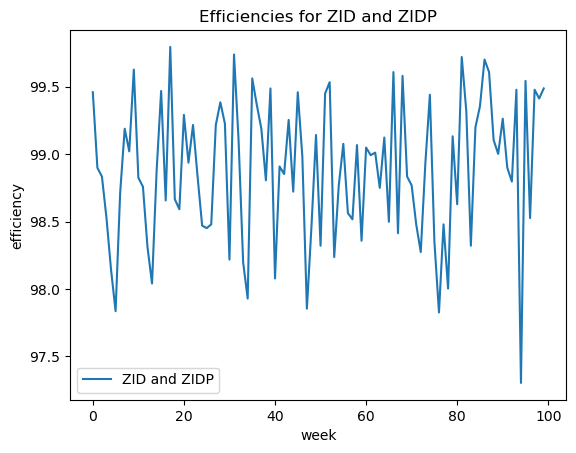

In [36]:
fig, ax = plt.subplots()  
ax.plot(data_table_10, label = 'ZID and ZIDP')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZID and ZIDP')
ax.legend()

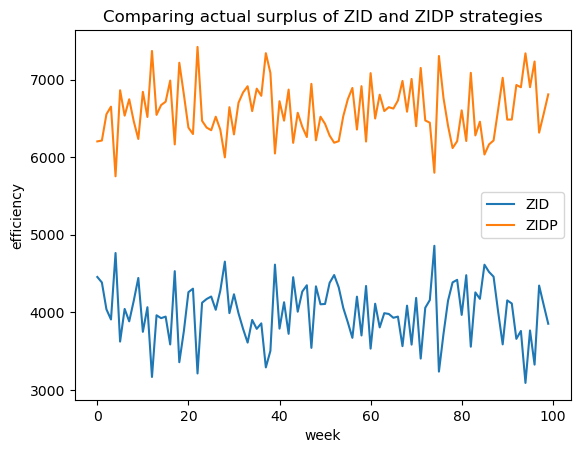

In [37]:
fig, ax = plt.subplots()  
ax.plot(ZID_surplus, label = 'ZID')
ax.plot(ZIDP_surplus, label = 'ZIDP')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZID and ZIDP strategies')
ax.legend()

## Runner for running weeks

In [38]:
# Deprecated with the inclusion of weeks in controls for the make_simulation function
def make_simulation_weeks(controls, trader_objects, debug=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    treat_number = 0
    num_weeks = chk(controls['num_weeks'], treat_number)
    num_periods = chk(controls['num_periods'], treat_number)
    num_rounds = chk(controls['num_rounds'], treat_number)
    grid_size = chk(controls['grid_size'], treat_number)
    num_traders = chk(controls['num_traders'], treat_number)
    num_units = chk(controls['num_units'], treat_number)
    lower_bound = chk(controls['lower_bound'], treat_number)
    upper_bound = chk(controls['upper_bound'], treat_number)
    num_trials = chk(controls['num_trials'], treat_number)
    
    effs = []
    type_effs = []
    locs = []
  

    # make agents
    agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
        type_eff = pr1.get_type_surplus()
        type_effs.append(type_eff)  
    return effs, type_effs, locs

## Runner for monte carlo simulations

In [39]:
num_trials = 100
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
trader_objects =[(ZID, 20)]

controls = {
    'num_trials': 10,
    'num_weeks': 50,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}

ex_sim_df, ex_sim = make_simulation_wide(controls, trader_objects)

Started Simulation
Finished Simulation


In [40]:
ex_sim_df.loc[0] # Initial location of the first trial

num_trials                                                         10
num_weeks                                                          50
num_periods                                                         7
num_rounds                                                          5
grid_size                                                          15
num_traders                                                        20
num_units                                                           8
lower_bound                                                       200
upper_bound                                                       600
trial                                                               0
week                                                               -1
period                                                             -1
efficiency                                                        NaN
type_effs                                                          []
period_contracts    

In [41]:
ex_sim_df.loc[1] # First period move + trades of first trial

num_trials                                                         10
num_weeks                                                          50
num_periods                                                         7
num_rounds                                                          5
grid_size                                                          15
num_traders                                                        20
num_units                                                           8
lower_bound                                                       200
upper_bound                                                       600
trial                                                               0
week                                                                0
period                                                              0
efficiency                                                        0.0
type_effs                                                          {}
period_contracts    

## Compare ZID vs ZIDA

In [42]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_trials': 1,
    'num_weeks': 50,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}


data_table_13, data_table_14, locs = make_simulation_weeks(controls, trader_objects)

ZID_surplus = []
ZIDA_surplus = []

for type_surplus in data_table_14:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDA' in type_surplus:
        ZIDA_surplus.append(type_surplus['ZIDA'])
    else:
        ZIDA_surplus.append(0)   

data_table_15 = [ZID_surplus, ZIDA_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

'\nfor loc in locs:\n    loc_d = {}\n    for g_loc in loc:\n        if g_loc in loc_d.keys():\n            loc_d[g_loc] += 1\n        else:\n            loc_d[g_loc] = 1\n    print(len(loc_d), loc_d)\n'

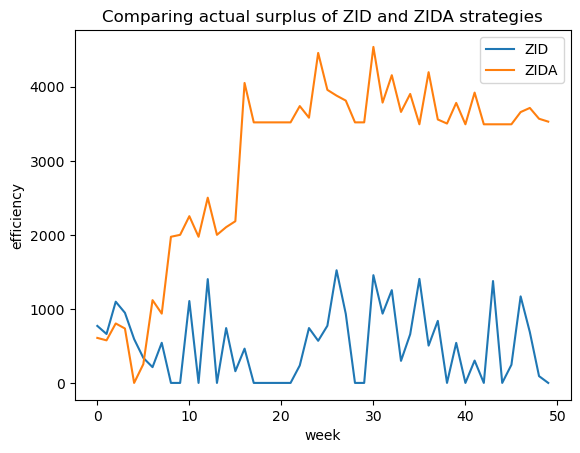

In [43]:
fig, ax = plt.subplots()  
ax.plot(ZID_surplus, label = 'ZID')
ax.plot(ZIDA_surplus, label = 'ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZID and ZIDA strategies')
ax.legend()

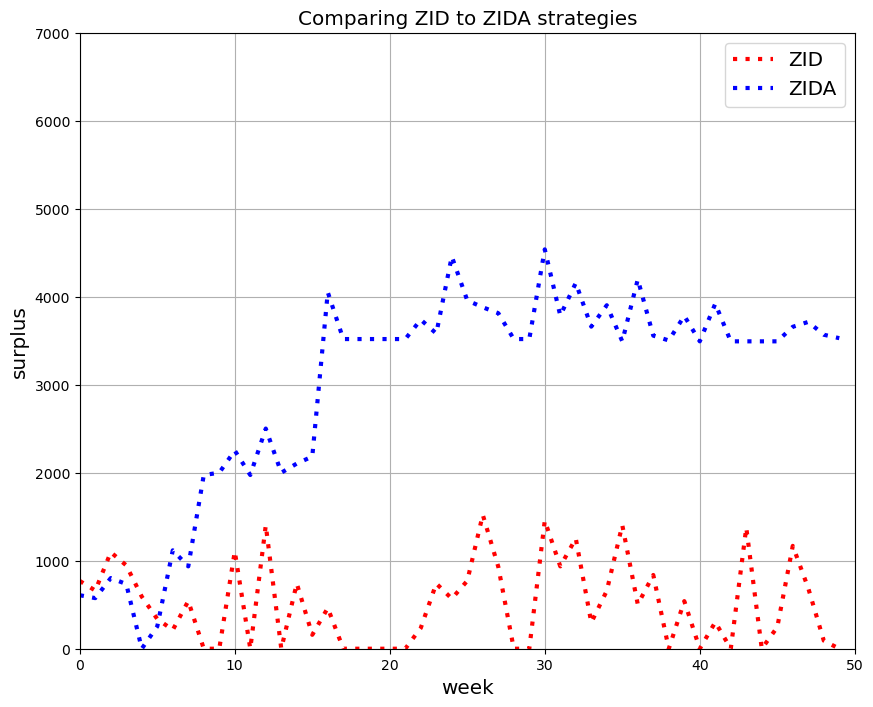

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZID_surplus, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, controls['num_weeks'])
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

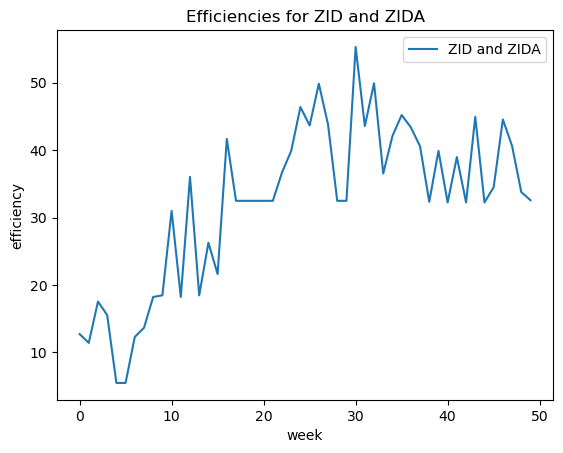

In [45]:
fig, ax = plt.subplots()  
ax.plot(data_table_13, label = 'ZID and ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZID and ZIDA')
ax.legend()

## Compare ZIDPA vs ZIDA

In [46]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 

trader_objects = [(ZIDPA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same

controls = {
    'num_trials': 1,
    'num_weeks': 50,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}

data_table_16, data_table_17, locs = make_simulation_weeks(controls, trader_objects)

ZIDPA_surplus = []
ZIDA_surplus = []
for type_surplus in data_table_17[1:]:
    ZIDPA_surplus.append(type_surplus['ZIDPA'])
    ZIDA_surplus.append(type_surplus['ZIDA'])

data_table_18 = [ZIDPA_surplus, ZIDA_surplus]


for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    #print(len(loc_d), loc_d)


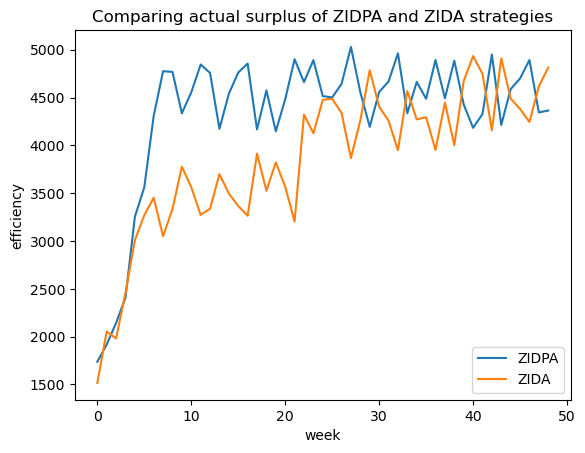

In [47]:
fig, ax = plt.subplots()  
ax.plot(ZIDPA_surplus, label = 'ZIDPA')
ax.plot(ZIDA_surplus, label = 'ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZIDPA and ZIDA strategies')
ax.legend()

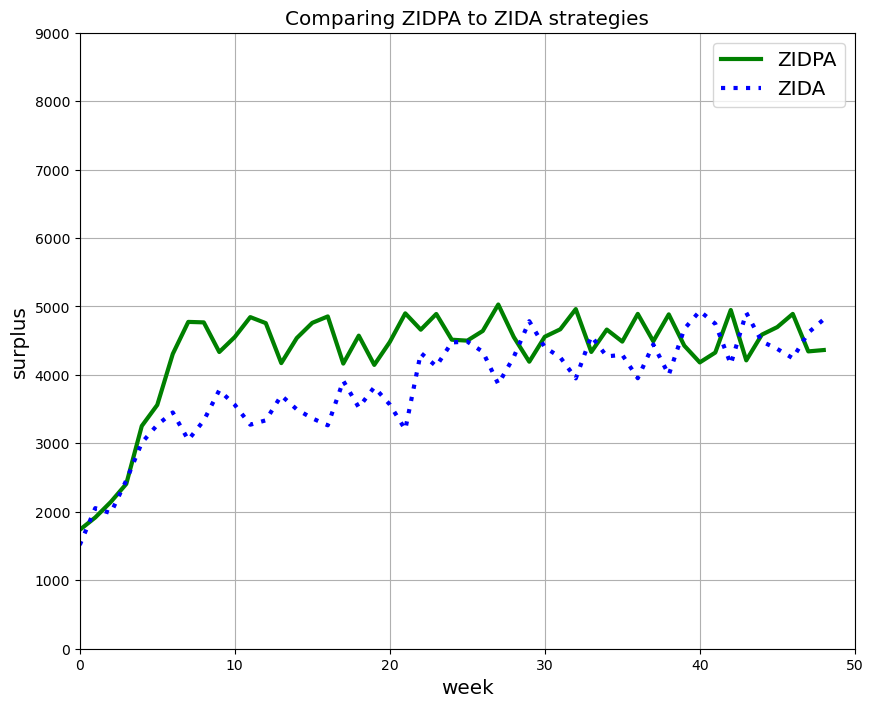

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, controls['num_weeks'])
ax.set_ybound(0, 9000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

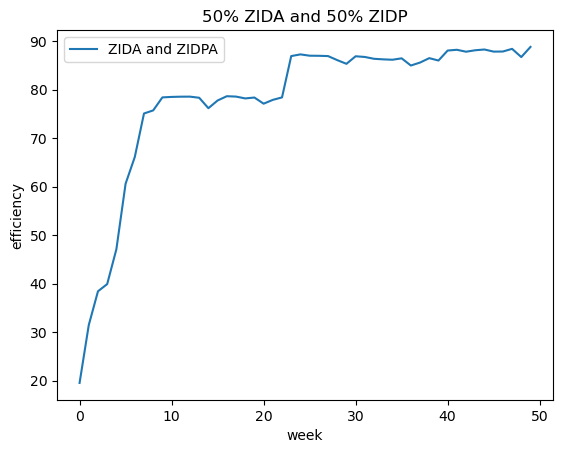

In [49]:
fig, ax = plt.subplots()  
ax.plot(data_table_16, label = 'ZIDA and ZIDPA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('50% ZIDA and 50% ZIDP')
ax.legend()

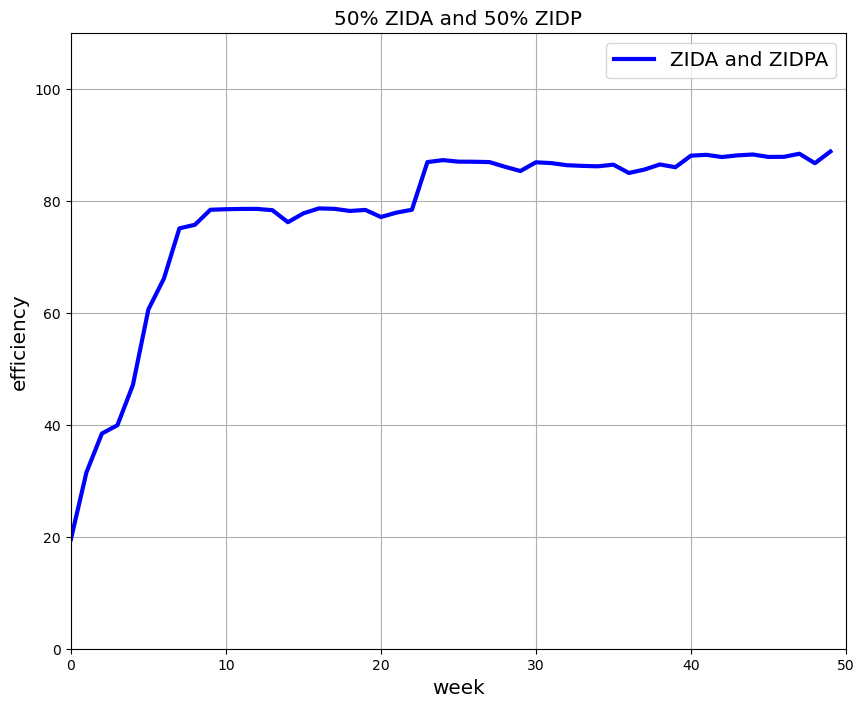

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_16, label = 'ZIDA and ZIDPA', linestyle = 'solid', color='blue', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, controls['num_weeks'])
ax.set_ybound(0, 110)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('50% ZIDA and 50% ZIDP', size = 'x-large')
ax.legend(fontsize='x-large')

## Compare ZIDPA to ZIDPR

In [51]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 
trader_objects = [(ZIDPA, 10), (ZIDPR,10)]     # List of artificial traders, length 2, can be same

controls = {
    'num_trials': 1,
    'num_weeks': 100,
    'num_periods': 7,
    'num_rounds': 5,
    'grid_size': 15,
    'num_traders': 20,
    'num_units': 8,
    'lower_bound': 200,
    'upper_bound': 600
}

data_table_19, data_table_20, locs = make_simulation_weeks(controls, trader_objects)

ZIDPA_surplus = []
ZIDPR_surplus = []
for type_surplus in data_table_20:
    if 'ZIDPA' in type_surplus:
        ZIDPA_surplus.append(type_surplus['ZIDPA'])
    else:
        ZIDPA_surplus.append(0)
    if 'ZIDPR' in type_surplus:
        ZIDPR_surplus.append(type_surplus['ZIDPR'])
    else:
        ZIDPR_surplus.append(0)   


data_table_21 = [ZIDPA_surplus, ZIDPR_surplus]



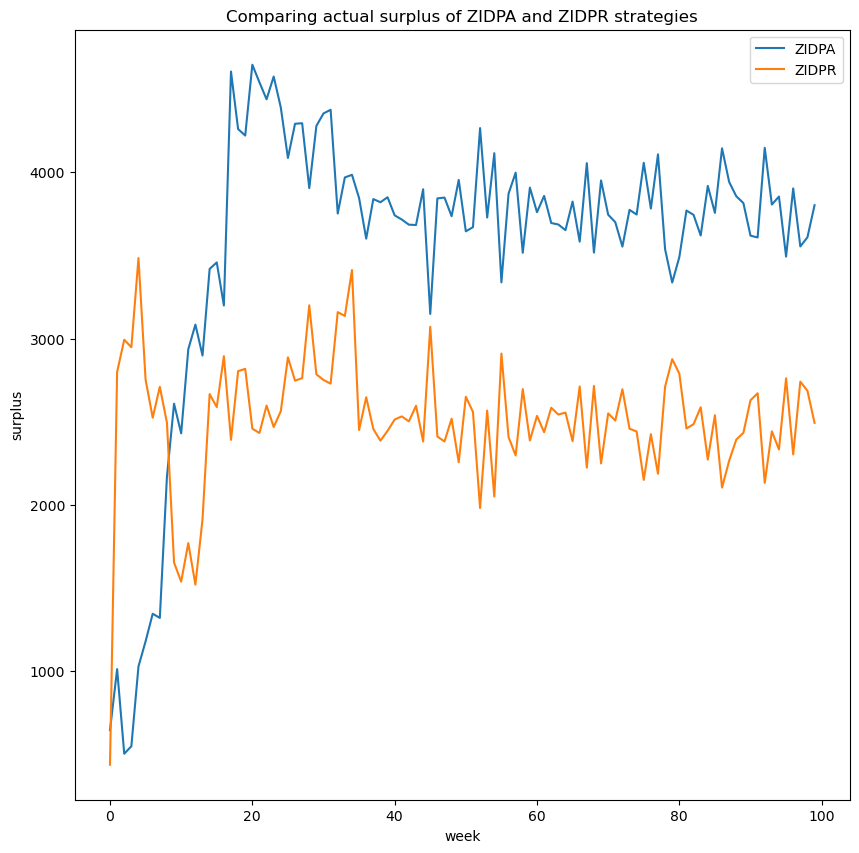

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))  
ax.plot(ZIDPA_surplus, label = 'ZIDPA')
ax.plot(ZIDPR_surplus, label = 'ZIDPR')
ax.set_xlabel('week') 
ax.set_ylabel('surplus') 
ax.set_title('Comparing actual surplus of ZIDPA and ZIDPR strategies')
ax.legend()

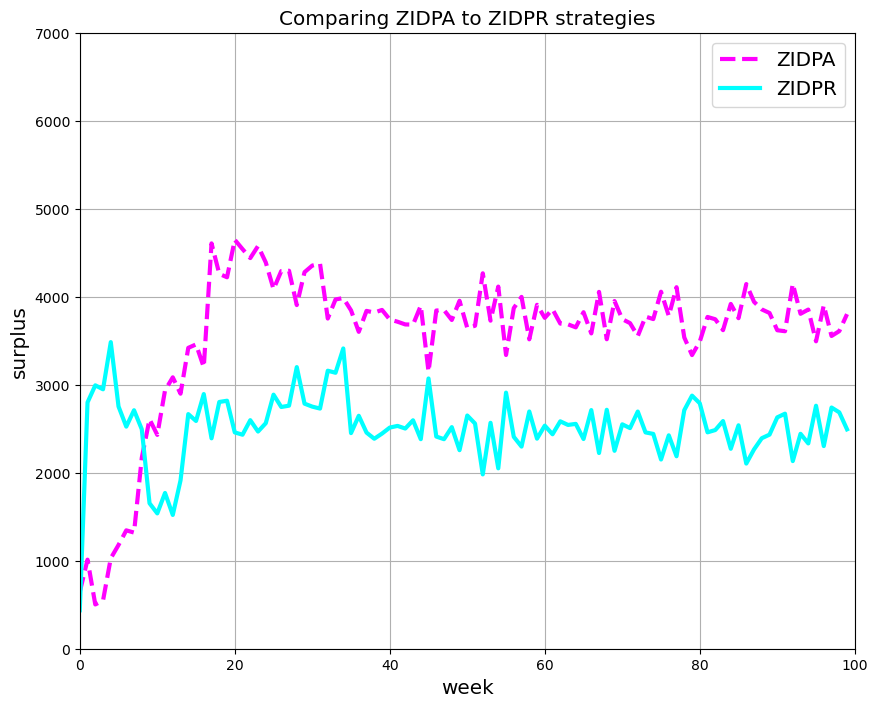

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'dashed', color='magenta', lw =3)
ax.plot(ZIDPR_surplus, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, controls['num_weeks'])
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDPR strategies', size = 'x-large')
ax.legend(fontsize='x-large')

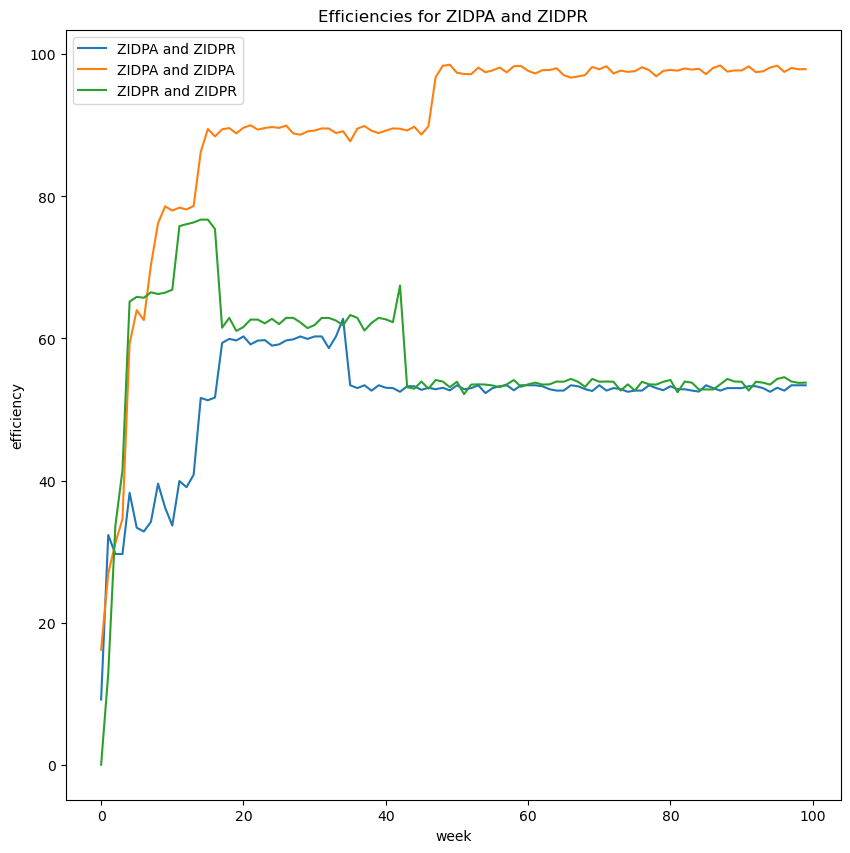

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))  
ax.plot(data_table_19, label = 'ZIDPA and ZIDPR')
ax.plot(data_table_8, label = 'ZIDPA and ZIDPA')
ax.plot(data_table_9, label = 'ZIDPR and ZIDPR')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZIDPA and ZIDPR')
ax.legend()

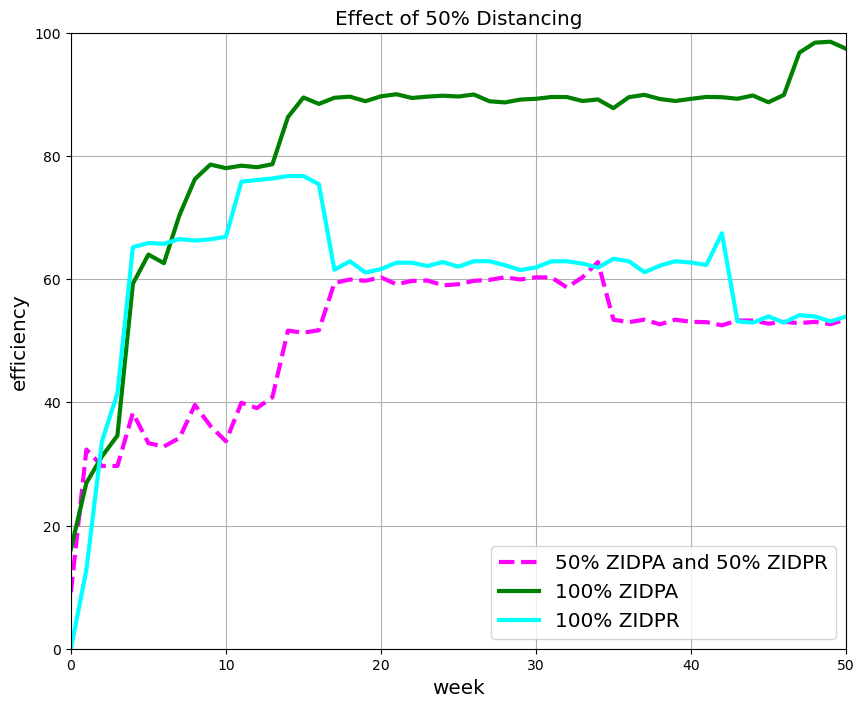

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_19, label = '50% ZIDPA and 50% ZIDPR', linestyle = 'dashed', color='magenta', lw =3)
ax.plot(data_table_8, label = '100% ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_9, label = '100% ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 50)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Effect of 50% Distancing', size = 'x-large')
ax.legend(fontsize='x-large')

# Regressions

In [ ]:
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [56]:
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 

zidpr_vals = [0, 2, 4, 6, 8, 10]
graphs_data = dict()
surplus_data = dict()
tot_traders = 20

for num_zidpr in zidpr_vals:
    
    trader_objects = [(ZIDPA, tot_traders-num_zidpr), (ZIDPR,num_zidpr)]     # List of artificial traders, length 2, can be same

    controls = {
        'num_trials': 1,
        'num_weeks': 50,
        'num_periods': 7,
        'num_rounds': 5,
        'grid_size': 15,
        'num_traders': 20,
        'num_units': 8,
        'lower_bound': 200,
        'upper_bound': 600
    }

    data_table_EFF, data_table_DESC, locs = make_simulation_weeks(controls, trader_objects)
    
    graphs_data[num_zidpr] = data_table_EFF
    
    ZIDPA_surplus = []
    ZIDPR_surplus = []
    for type_surplus in data_table_20:
        if 'ZIDPA' in type_surplus:
            ZIDPA_surplus.append(type_surplus['ZIDPA'])
        else:
            ZIDPA_surplus.append(0)
        if 'ZIDPR' in type_surplus:
            ZIDPR_surplus.append(type_surplus['ZIDPR'])
        else:
            ZIDPR_surplus.append(0)   


    data_table_SURPLUS = [ZIDPA_surplus, ZIDPR_surplus]
    surplus_data[num_zidpr] = data_table_SURPLUS
    

In [57]:
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 

zidpr_vals = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] # Number of zidpr (social distancing) traders in the simulation
tot_traders = 20

iterations = 20 # Rows 
avg_data = np.empty((iterations, len(zidpr_vals)))
last_data = np.empty((iterations, len(zidpr_vals))) 
for iteration in range(iterations):
    graphs_data = dict()
    surplus_data = dict()
    
    for i, num_zidpr in enumerate(zidpr_vals):
        
        trader_objects = [(ZIDPA, tot_traders-num_zidpr), (ZIDPR,num_zidpr)]     # List of artificial traders, length 2, can be sam
        
        controls = {
            'num_trials': 1,
            'num_weeks': 50,
            'num_periods': 7,
            'num_rounds': 5,
            'grid_size': 15,
            'num_traders': 20,
            'num_units': 8,
            'lower_bound': 200,
            'upper_bound': 600
        }    

        data_table_EFF, data_table_DESC, locs = make_simulation_weeks(controls, trader_objects)

        graphs_data[num_zidpr] = data_table_EFF
        
        # TODO remake with pandas frames
        avg_data[iteration][i] = np.mean(data_table_EFF)
        last_data[iteration][i] = data_table_EFF[-1]        
        

In [58]:
avg_dataframe = pd.DataFrame(data=avg_data, columns=zidpr_vals)
last_dataframe = pd.DataFrame(data=last_data, columns=zidpr_vals)

In [59]:
last_dataframe.T.stack()

0   0     74.401734
    1     87.688271
    2     90.071455
    3     86.314211
    4     93.857115
            ...    
20  15    47.614959
    16    58.926900
    17    54.988399
    18    63.653324
    19    57.016974
Length: 220, dtype: float64

In [60]:
#result_avg = linregress(avg_dataframe[avg_dataframe.columns[1:]].T,y=avg_dataframe['index'].T)

In [62]:
stacked_avg = avg_dataframe.T.stack()
stacked_avg = stacked_avg.reset_index()
stacked_avg = stacked_avg.rename(columns={'level_0':'num_zidpr', 'level_1':'trial', 0: 'efficiency'})
stacked_avg

,num_zidpr,trial,efficiency
0,0,0,68.696439
1,0,1,71.176173
2,0,2,75.470854
3,0,3,75.458005
4,0,4,84.323512
...,...,...,...
215,20,15,42.321504
216,20,16,45.718623
217,20,17,46.778257
218,20,18,58.323779


In [63]:
# Avg Efficiency Regression
X = stacked_avg[['num_zidpr']]
Y = stacked_avg[['efficiency']]
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # regress
Y_pred = linear_regressor.predict(X)  # fitted

In [64]:
linear_regressor.coef_

array([[-1.66548294]])

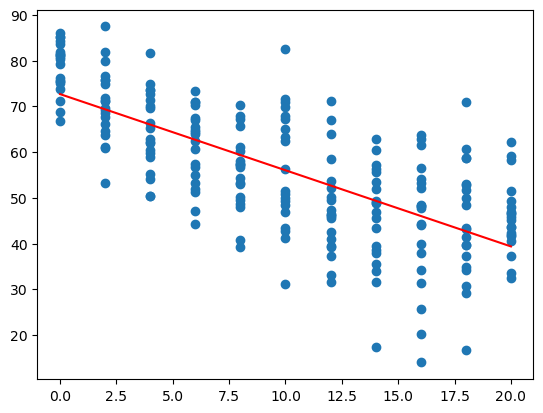

In [65]:
plt.scatter(X.stack(), Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [66]:
stacked_trm = last_dataframe.T.stack()
stacked_trm = stacked_trm.reset_index()
stacked_trm = stacked_trm.rename(columns={'level_0':'num_zidpr', 'level_1':'trial', 0: 'efficiency'})
stacked_trm

,num_zidpr,trial,efficiency
0,0,0,74.401734
1,0,1,87.688271
2,0,2,90.071455
3,0,3,86.314211
4,0,4,93.857115
...,...,...,...
215,20,15,47.614959
216,20,16,58.926900
217,20,17,54.988399
218,20,18,63.653324


In [67]:
# Terminal Efficiency Regression
X = stacked_trm[['num_zidpr']]
Y = stacked_trm[['efficiency']]
linear_regressor = LinearRegression() 
linear_regressor.fit(X, Y)  # regress
Y_pred = linear_regressor.predict(X)  # fitted

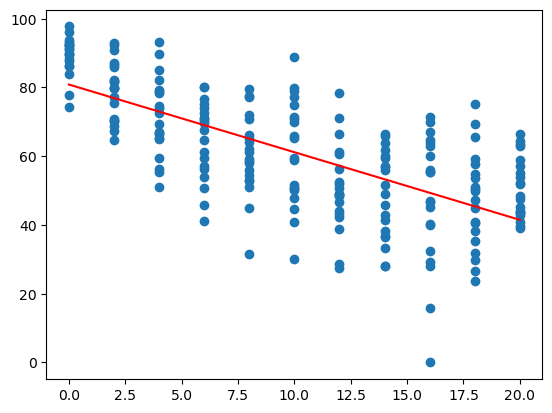

In [68]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [69]:
linear_regressor.coef_

array([[-1.96785378]])

# Visualization of Agent Actions

In [ ]:
def three_d_grid(grid_size):
    """Transforms a grid size into a projected-vector 3d grid - represented as a nm and mn vectors"""    
    # create dimmensions - currently only for square grid of nXn
    colnames = ['D1', 'D2']
    grid_base = []
    n = np.arange(grid_size)
    m = np.arange(grid_size)
    for n1 in n:
        for m1 in m:
            grid_base.append([n1, m1])

    grid_df = pd.DataFrame(data=grid_base, columns=colnames)
    return grid_df

def plottable_locs(locs, grid_df, investigated="Agents"):
    """Plots a location-agents dictionary onto a 3d grid based projects vectors"""
    grid_new = grid_df.copy()
    grid_new[investigated] = 0
    for loc in locs.keys():
        agent_at_key = len(locs[loc])
        d1 = loc[0]
        d2 = loc[1]
        spot_ind = grid_new[(grid_new['D1'] == d1) & (grid_new['D2'] == d2)].index
        grid_new[investigated].iloc[spot_ind] = agent_at_key
    return grid_new

def collate_loc_plots(sim_df, investigated="Agents"):
    """Create large stacked DF with agent locations for every trial, week, and period
        sim_df: dataframe of results
        investigated: the value to report in the collated plotted grid df
        
        returns:
            dataframe of stacked form with the grid and observed vars at the points per trial, week, period
    """
    num_trials = sim_df['num_trials'].loc[0]
    num_weeks = sim_df['num_weeks'].loc[0]
    num_periods = sim_df['num_periods'].loc[0]
    num_rounds = sim_df['num_rounds'].loc[0]
    grid_size = sim_df['grid_size'].loc[0]
    num_traders = sim_df['grid_size'].loc[0]

    grd = three_d_grid(grid_size)
    
    control_cols = ['num_trials', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound']
    rel_df = sim_df[list(set(sim_df.columns) - set(control_cols))]

    out_df = pd.DataFrame()

    # Traverse the simulation df and save stacked plots
    for trial in range(num_trials):
        trial_df = rel_df[rel_df['trial']==trial]
        init_ind = trial_df[(trial_df['week']==-1) & (trial_df['period']==-1)].index
        init_loc = trial_df['period_locs'].loc[init_ind].values[0]
        init_plot = plottable_locs(init_loc, grd)
        init_plot['trial'] = trial
        init_plot['week'] = -1
        init_plot['period'] = -1
        out_df = pd.concat([out_df, init_plot])
        for week in range(num_weeks):
            week_df = trial_df[trial_df['week']==week]
            for period in range(num_periods):
                per_ind = week_df[week_df['period']==period].index
                per_loc = week_df['period_locs'].loc[per_ind].values[0]
                per_plot = plottable_locs(per_loc, grd)
                per_plot['trial'] = trial
                per_plot['week'] = week
                per_plot['period'] = period
                out_df = pd.concat([out_df, per_plot])

    return out_df

def graph_plotted(plotted, title_val=None, hue_val="Agents", hue_norm_val=(0, 1), size_val="Agent", size_norm_val=(0, 1), legend=False, palette="hot_r",
                 integer_bar=True, subtitle=False):
    """Visualize the data on a 2D grid to show the locations and values of the investigated value"""
    
    g = sns.relplot(
        data=plotted,
        x="D1", y="D2", hue=hue_val, size="Agents",
        palette=palette, hue_norm=hue_norm_val, edgecolor=".7",
        height=10, sizes=(35, 400), size_norm=size_norm_val, legend=False
    )

    if not subtitle:
        subtitle = ""
    
    # Tweak the figure to finalize
    g.set(xlabel=subtitle, ylabel="", aspect="equal", xticks=[], yticks=[], xticklabels=[], yticklabels=[], title=title_val)
    g.despine(left=True, bottom=True)
    g.ax.margins(.03)
    plt.grid()

    if legend:
        bar = g.figure.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_val, cmap=palatte),
             ax=plt.gca(), label=hue_val, aspect=100, shrink=0.8)
        
        if integer_bar:
            bar.locator = tckr.MaxNLocator(integer=True)
        

    return g



In [70]:
controls = {
    'num_trials': 2,
    'num_weeks': 10,
    'num_periods': 10,
    'num_rounds': 10,
    'grid_size': 10,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600    
}

sim_df, sim_t = make_simulation_wide(controls, trader_objects=[[ZID, 10]])

Started Simulation
Finished Simulation


In [71]:
sim_df.head()

,num_trials,num_weeks,num_periods,num_rounds,grid_size,num_traders,num_units,lower_bound,upper_bound,trial,week,period,efficiency,type_effs,period_contracts,period_locs
0,2,10,10,10,10,10,6,200,600,0,-1,-1,NaN,[],[],"{(4, 9): ['B_1_ZID'], (0, 3): ['B_2_ZID'], (9,..."
1,2,10,10,10,10,10,6,200,600,0,0,0,0.000000,{},[],"{(5, 8): ['B_1_ZID'], (1, 3): ['B_2_ZID'], (9,..."
2,2,10,10,10,10,10,6,200,600,0,0,1,23.483366,{'ZID': 960},"[(1, 310, B_3_ZID, S_4_ZID, 0, 593, 0, 202), (...","{(6, 9): ['B_1_ZID'], (1, 2): ['B_2_ZID'], (9,..."
3,2,10,10,10,10,10,6,200,600,0,0,2,23.483366,{'ZID': 960},[],"{(6, 8): ['B_1_ZID'], (0, 1): ['B_2_ZID'], (9,..."
4,2,10,10,10,10,10,6,200,600,0,0,3,23.483366,{'ZID': 960},[],"{(5, 8): ['B_1_ZID'], (0, 1): ['B_2_ZID'], (9,..."


In [72]:
# Display (Relevant) Columns
control_cols = ['num_trials', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound']
    
sim_df[list(set(sim_df.columns) - set(control_cols))]

,week,period,efficiency,period_contracts,trial,type_effs,period_locs
0,-1,-1,NaN,[],0,[],"{(4, 9): ['B_1_ZID'], (0, 3): ['B_2_ZID'], (9,..."
1,0,0,0.000000,[],0,{},"{(5, 8): ['B_1_ZID'], (1, 3): ['B_2_ZID'], (9,..."
2,0,1,23.483366,"[(1, 310, B_3_ZID, S_4_ZID, 0, 593, 0, 202), (...",0,{'ZID': 960},"{(6, 9): ['B_1_ZID'], (1, 2): ['B_2_ZID'], (9,..."
3,0,2,23.483366,[],0,{'ZID': 960},"{(6, 8): ['B_1_ZID'], (0, 1): ['B_2_ZID'], (9,..."
4,0,3,23.483366,[],0,{'ZID': 960},"{(5, 8): ['B_1_ZID'], (0, 1): ['B_2_ZID'], (9,..."
...,...,...,...,...,...,...,...
197,9,5,28.424364,[],1,{'ZID': 994},"{(4, 5): ['B_1_ZID'], (3, 6): ['B_2_ZID'], (1,..."
198,9,6,28.424364,[],1,{'ZID': 994},"{(5, 5): ['B_1_ZID'], (3, 6): ['B_2_ZID'], (0,..."
199,9,7,28.424364,[],1,{'ZID': 994},"{(4, 6): ['B_1_ZID'], (2, 7): ['B_2_ZID'], (0,..."
200,9,8,28.424364,[],1,{'ZID': 994},"{(3, 7): ['B_1_ZID', 'B_2_ZID'], (1, 0): ['B_3..."


In [73]:
# Format: Round, Contract Price, Buyer, Seller, 
# ex_contract = (round, price, buyer_id, seller_id, b_cur_unit, b_cur_value, s_cur_unit, s_cur_cost)
# In so far as I understand this correctly - cur_value is the subjective valuation of the unit under contract from the perspective of the buyer and of the seller
# and the cur_unit number number is which unit it is (0 indexed)
# Aslo note these are only successful contracts, not attempted contracts
# Round number indicates in which round of in-place market operations the contract took place - there can be many rounds in a period - here there is 10
sim_df.loc[1].period_contracts

[]

In [74]:
# Initial Location of agents
sim_df.loc[0].period_locs

{(4, 9): ['B_1_ZID'],
 (0, 3): ['B_2_ZID'],
 (9, 7): ['B_3_ZID'],
 (5, 6): ['B_4_ZID'],
 (1, 8): ['B_5_ZID'],
 (4, 5): ['S_1_ZID'],
 (3, 5): ['S_2_ZID'],
 (1, 4): ['S_3_ZID'],
 (7, 7): ['S_4_ZID'],
 (7, 9): ['S_5_ZID']}

In [75]:
# Effect of one period movement
sim_df.loc[1].period_locs

{(5, 8): ['B_1_ZID'],
 (1, 3): ['B_2_ZID'],
 (9, 8): ['B_3_ZID'],
 (5, 7): ['B_4_ZID'],
 (2, 9): ['B_5_ZID'],
 (4, 4): ['S_1_ZID'],
 (2, 5): ['S_2_ZID'],
 (2, 4): ['S_3_ZID'],
 (8, 8): ['S_4_ZID'],
 (7, 9): ['S_5_ZID']}

In [77]:
# Project inital onto space
gd_size = sim_df['grid_size'][0]
ex_grid = three_d_grid(gd_size)
init_plotted = plottable_locs(sim_df.loc[0].period_locs, ex_grid)
# Display non-zero locations
nz_inds = init_plotted['Agents'].to_numpy().nonzero()
init_plotted.iloc[nz_inds]

,D1,D2,Agents
3,0,3,1
14,1,4,1
18,1,8,1
35,3,5,1
45,4,5,1
49,4,9,1
56,5,6,1
77,7,7,1
79,7,9,1
97,9,7,1


In [78]:
first_plotted = plottable_locs(sim_df.loc[1].period_locs, ex_grid)
nz_inds = first_plotted['Agents'].to_numpy().nonzero()
first_plotted.iloc[nz_inds]

,D1,D2,Agents
13,1,3,1
24,2,4,1
25,2,5,1
29,2,9,1
44,4,4,1
57,5,7,1
58,5,8,1
79,7,9,1
88,8,8,1
98,9,8,1


In [80]:
locs_plot_df = collate_loc_plots(sim_df, investigated="Agents")
locs_plot_df

,D1,D2,Agents,trial,week,period
0,0,0,0,0,-1,-1
1,0,1,0,0,-1,-1
2,0,2,0,0,-1,-1
3,0,3,1,0,-1,-1
4,0,4,0,0,-1,-1
...,...,...,...,...,...,...
95,9,5,0,1,9,9
96,9,6,0,1,9,9
97,9,7,1,1,9,9
98,9,8,0,1,9,9


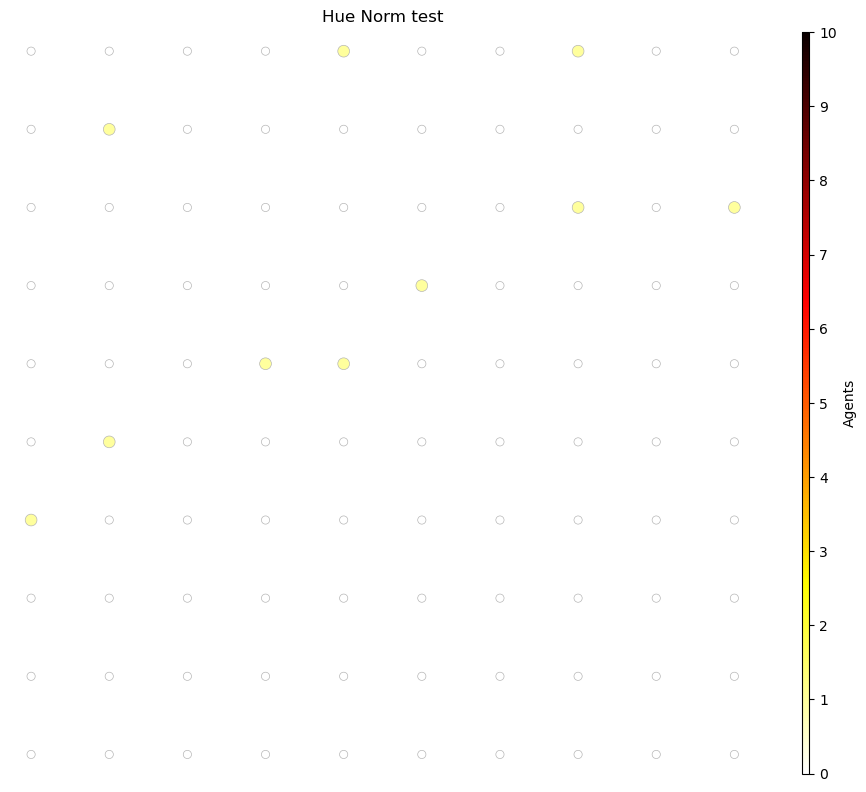

In [82]:
plotted = init_plotted
title_val="Hue Norm test"
hue_val="Agents"
#hue_norm_val=(-1, 1)
hue_norm_val= colors.Normalize(vmin=0, vmax=10)
size_val="Agent"
size_norm_val=hue_norm_val
legend=True
# palette = "YlOrRd"
palette = "hot_r"
integer_bar = True

graph_plotted(plotted, title_val=title_val, hue_val=hue_val, hue_norm_val=hue_norm_val, size_val=size_val, size_norm_val=size_norm_val, legend=legend, pallatte=palette,
                 integer_bar=integer_bar)

plt.grid(False)

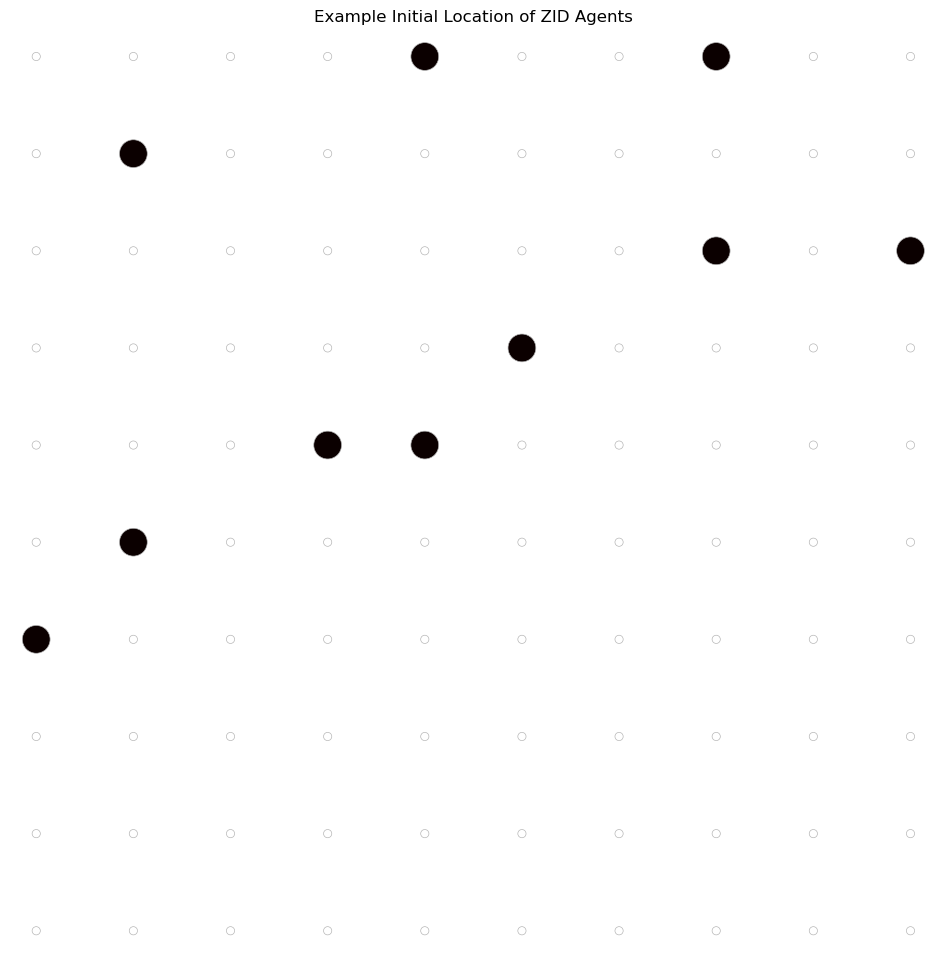

In [83]:
# Show example visualization as a relplot 
# here size and color are the same metric - they are both number of agents
# Ideas for future - add local price or local efficiency at as color
title="Example Initial Location of ZID Agents"
graph_plotted(init_plotted, title_val=title)
plt.show()

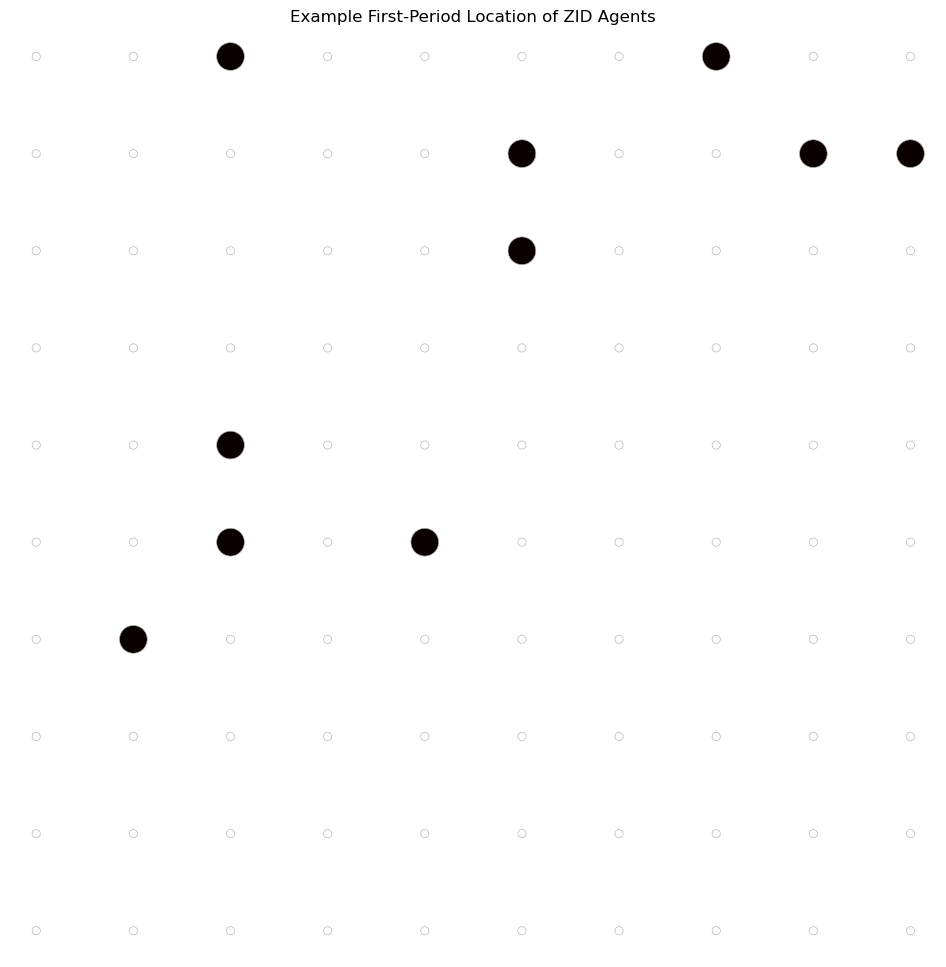

In [84]:
title="Example First-Period Location of ZID Agents"
graph_plotted(first_plotted, title_val=title)
plt.show()

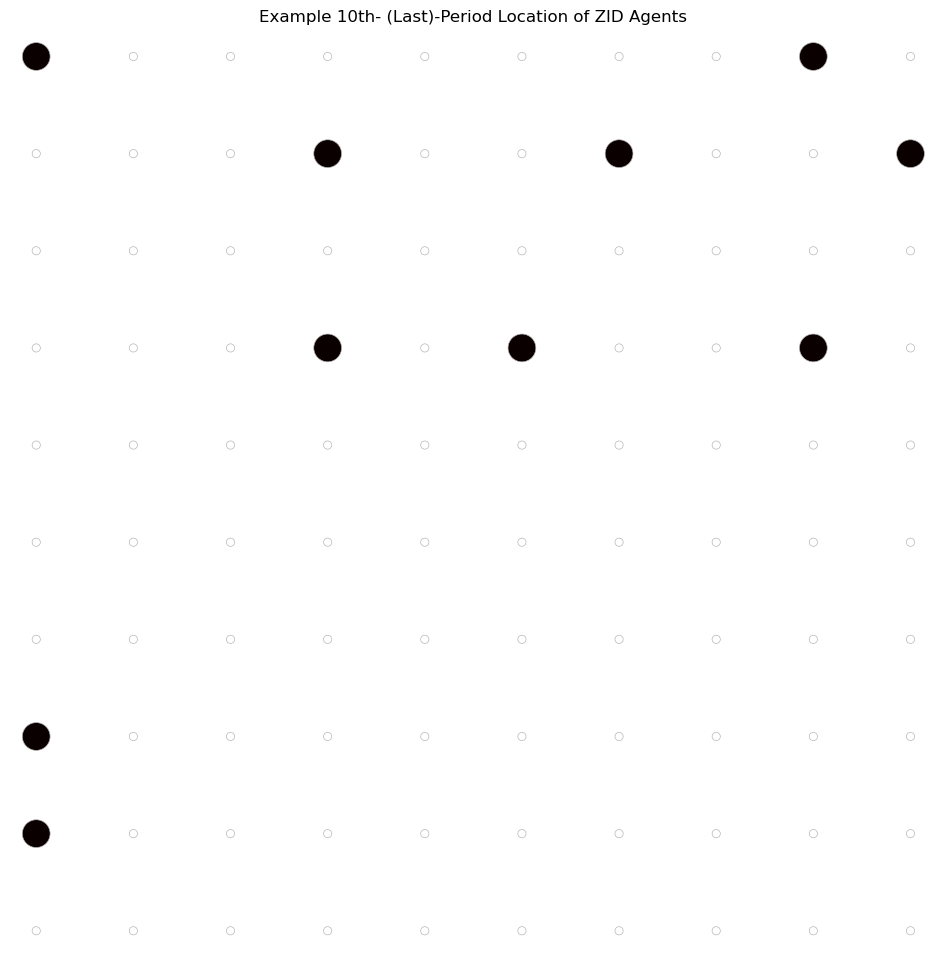

In [85]:
last_plotted = plottable_locs(sim_df.loc[10].period_locs, ex_grid)
title="Example 10th- (Last)-Period Location of ZID Agents"
graph_plotted(last_plotted, title_val=title)
plt.show()

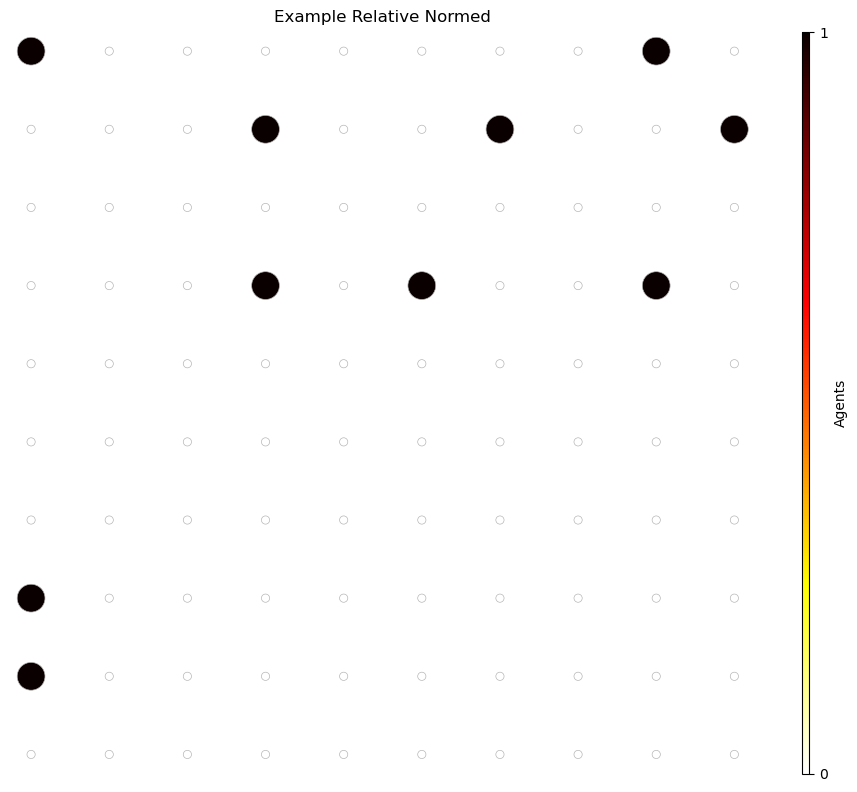

In [86]:
title="Example Relative Normed"
hue_norm_rel = colors.Normalize(vmin=0, vmax=np.max(last_plotted['Agents'])) # Relative normalization - to max observed
graph_plotted(last_plotted, title_val=title, hue_norm_val=hue_norm_rel, legend=True)
plt.show()

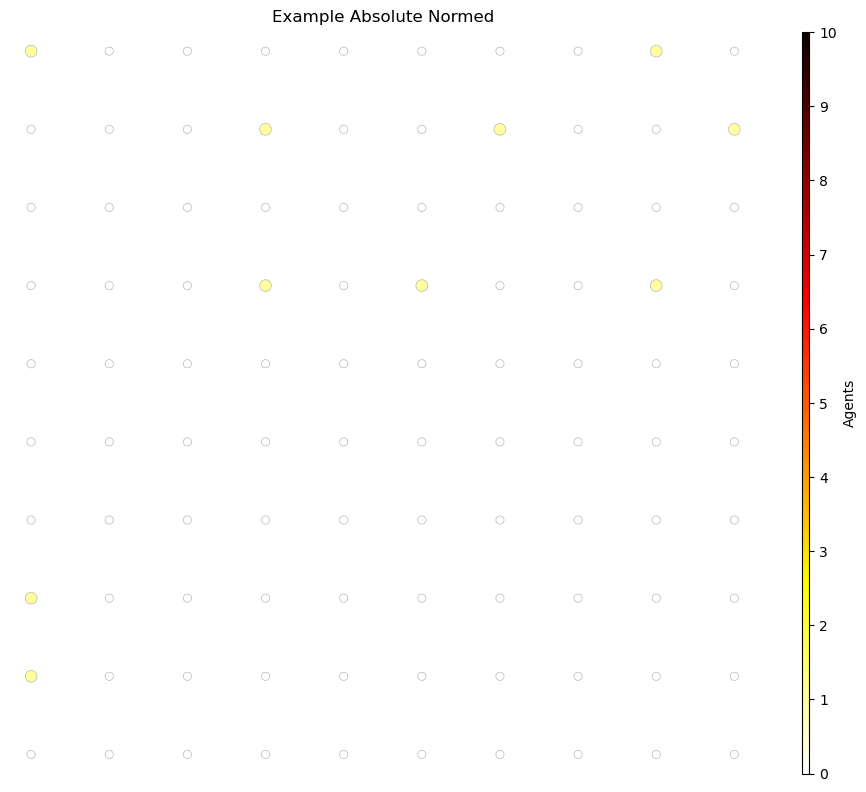

In [87]:
# def graph_plotted(plotted, title_val=None, hue_val="Agents", hue_norm_val=(-1, 1), size_val="Agent", size_norm_val=(-0.2, 0.8)):
title="Example Absolute Normed"
hue_norm_abs = colors.Normalize(vmin=0, vmax=10) # Absolute normalization - to max possible val - here 10
graph_plotted(last_plotted, title_val=title, hue_norm_val=hue_norm_abs, size_norm_val=hue_norm_abs, legend=True)
plt.show()

In [88]:
import warnings
import moviepy.video.io.ImageSequenceClip
from PIL import Image, ImageFile
# import PIL and PIL.ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

default_movie_stem = "loc_movie"
default_graph_folder = "loc_plots"
if not os.path.isdir(default_graph_folder):
    os.mkdir(default_graph_folder)

def to_len_str(number, str_len):
    base_str = str(number)
    new_str = '0'*(str_len-len(base_str)) + base_str
    return new_str

def movie_plotted(collated_plotted, movie_name=None, graph_folder=None, title_val=None, hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True):
    """
    collated_plotted: one trial (or an average of trials) plotted using 
    movie_name: The name to save the movie under (if not provided - uses default for the notebook + timestamp)
    graph_folder: The name of the folder to save the graphs in (if not provided - uses default for the notebook + new folder timestamp)
    title_val: what title to use
    hue_val: what to place the hue on
    size_val: what to place size on
    scale: the way in which normalization will be applied to graph hues and sizes
    hue_max: used for normalization of hue in absolute scale case
    size_max: used for normalization of size in absolute scale case
    """
    timestamp = int(time.time()*1000000) # integer to not have issues with os
    if graph_folder is None:
        graph_folder = default_graph_folder + "/plots_" + str(timestamp)
    else:
        graph_folder = default_graph_folder + "/" + graph_folder
        
    if movie_name is None:
        movie_name = graph_folder + "/movie.mp4"
    else:
        movie_name = graph_folder + "/" + movie_name
        
    if scale == "absolute":
        if hue_max is None:
            raise ValueError("Hue max must be defined for absolute scaling")
        if size_max is None:
            raise ValueError("Size max must be defined for absolute scaling")
    elif scale == "relative":
        hue_max = np.max(collated_plotted[hue_val])
        size_max = np.max(collated_plotted[size_val])
        
    hue_norm = colors.Normalize(vmin=0, vmax=hue_max)
    size_norm = colors.Normalize(vmin=0, vmax=size_max)
    
    # Check if directories exists
    if not os.path.isdir(graph_folder):
        os.mkdir(graph_folder)

    if os.path.isfile(movie_name):
        warnings.warn("Movie name already used")
        return
        # raise ValueError("Movie name already used")


    if week_max is None:
        week_max = np.max(collated_plotted['week'])

    week_digits = len(str(week_max))

    if period_max is None:
        period_max = np.max(collated_plotted['period'])

    period_digits = len(str(week_max))

    img_names = []
    if include_init:
        init_plot = collated_plotted[(collated_plotted['week']==-1) & (collated_plotted['period']==-1)]
        init_name = graph_folder + "/init_plot.png"
        img_names.append(init_name)
        if subtitle:
                subtitle = "Initial Position"
        init_graph = graph_plotted(init_plot, title_val=title_val, hue_val=hue_val, hue_norm_val=hue_norm, size_val=size_val, size_norm_val=size_norm, 
                                   legend=True, subtitle=subtitle)
        plt.savefig(init_name)
        plt.close()
    
    for week in range(0, week_max+1):
        for period in range(0, period_max+1):
            this_plot = collated_plotted[(collated_plotted['week']==week) & (collated_plotted['period']==period)]
            weekstr = to_len_str(week, week_digits)
            prdstr = to_len_str(period, period_digits)
            this_image_name = graph_folder + "/w" + weekstr + "p" + prdstr + "_plot.png"
            img_names.append(this_image_name)
            if subtitle:
                subtitle = "Week: "+weekstr+"; Period: "+prdstr
            
            this_graph = graph_plotted(this_plot, title_val=title_val, hue_val=hue_val, hue_norm_val=hue_norm, size_val=size_val, size_norm_val=size_norm,
                                      legend=True, subtitle=subtitle)
            plt.savefig(this_image_name)
            plt.close()
            

    # Create movie out of plotted graphs
    fps = fps
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(img_names, fps=fps)
    clip.write_videofile(movie_name)
    

In [89]:
# Example ZID Movie - Single Run
fd_name = "Example_ZID_Single"
m_name = "Example_ZID_Single.mp4"
one_trial = locs_plot_df[locs_plot_df['trial']==0]
movie_plotted(one_trial, movie_name=m_name, graph_folder=fd_name, title_val="Example of ZID Traders - Single Run", hue_val="Agents", size_val="Agents", scale="relative", 
              hue_max=None, size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

ValueError: Movie name already used

In [ ]:
# Example ZID Movie - Average of Multiple Runs
avgdf = locs_plot_df.groupby(["D1","D2","week","period"]).mean().reset_index()
fd_name = "Example_ZID_Average"
m_name = "Example_ZID_Average.mp4"
movie_plotted(avgdf, movie_name=m_name, graph_folder=fd_name, title_val="Example of ZID Traders - Averaged", hue_val="Agents", size_val="Agents", scale="relative", 
              hue_max=None, size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
# One Trial with many weeks - ZIDA
controls = {
    'num_trials': 1,
    'num_weeks': 100,
    'num_periods': 20,
    'num_rounds': 10,
    'grid_size': 10,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600    
}

sim2_df, sim_t = make_simulation_wide(controls, trader_objects=[[ZIDA, 10]])

In [ ]:
zida_locs = collate_loc_plots(sim2_df, investigated="Agents")

In [ ]:
# Example ZIDA Movie - Average of Multiple Runs
fd_name = "Example_ZIDA_Run"
m_name = "Example_ZIDA_Runa.mp4"
movie_plotted(zida_locs, movie_name=m_name, graph_folder=fd_name, title_val="Example of ZIDA Traders - Single Run", hue_val="Agents", size_val="Agents", scale="relative", 
              hue_max=None, size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
def eval_state_equality(state_a, state_b, equality_on, max_error=0.0, condition_function=None):
    # NOTE - Sates MUST be numeric if condition_function is not provided
    if condition_function is None:
        if type(equality_on) is list:
            raise ValueError("The condition_function must be provided if using a list type of equality_on")
        bigger_state = np.max([state_a[equality_on].values[0], state_b[equality_on].values[0]])
        smaller_state = np.min([state_a[equality_on].values[0], state_b[equality_on].values[0]])
        return smaller_state + max_error >= bigger_state
    else:
        return condition_function(state_a, state_b, equality_on, max_error)
    

def eval_plot_equality(state_a, state_b, equality_on, max_error=0.0, grid_deviation=0, condition_function=None):
    """
    Custom function to map plots into an equality.
        Note this function is HIGHLY computationally intensive - so be careful when using it 
        - and the higher the grid deviation, the exponentially higher the computational costs
        Note: Equality is defined as equality on the exact square or within on grid_deviation away (default is exact)
        Note: Currently implemented for square grids - but can be changed to other types in future
        state_a
        equality_on: 
    """

    # Assume equal - then prove false (if false) by contradiction - cheaper computationally
    grid_is_equal = True
    
    # Traverse the grid to measure non-equality
    grid_size = np.max(state_a['D1'])
    for d1 in range(grid_size):
        for d2 in range(grid_size):

            # Assume box is non-equal - cheaper to prove box is equal
            box_is_equal = False
            
            # Compare equality within the deviation grid
            # if ANY points within the box are equal, the box is equal
            min_d1 = np.max([0, d1-grid_deviation])
            max_d1 = np.min([d1, grid_size])
            min_d2 = np.max([0, d2-grid_deviation])
            max_d2 = np.min([d2, grid_size])
            for n1 in range(min_d1, max_d1+1):
                for n2 in range(min_d2, max_d2+1):
                    point_state_a = state_a[(state_a["D1"]==n1) & (state_a["D2"]==n2)]
                    point_state_b = state_b[(state_b["D1"]==n1) & (state_b["D2"]==n2)]
                    point_is_equal = eval_state_equality(point_state_a, point_state_b, equality_on, max_error, condition_function)

                    # If this point is equal, set box equal and jump out
                    if point_is_equal:
                        box_is_equal = True
                        break
                if box_is_equal:
                    break
            
            # if after traversing the box, still not equal, flag the grid as not equal and return
            if not box_is_equal:
                grid_is_equal = False
                return grid_is_equal
                
    return grid_is_equal

def eval_cyclic_states(stored_states, max_error=0, state_repetitions=20, full_cycles=False, condition_function=None):
    raise NotImplementedError("Cyclic eval states coming in the future")
    # Count how many states are the same
    # full_cycles: boolean (optional): if the evaluation should just be the number of repetition or if it should be the number of cycles
    # This evaluation method is extremely computationally intensive
    pass

In [ ]:
# Note the above simulation resulted in no changes in the agent positions after week 08 period 19 - but the video and simulation is much longer ...
# So we need a function to indicate at what point the video should cut off by having a measure of the equilibirum condition investigated
def calc_sim_equilibrium_point(sim_df, equality_on, max_error=0.0, grid_eval=False, grid_deviation=0, week_only=False, cyclic=False, full_cycles=False, 
                               condition_function=None, state_repetitions = 20, has_neg=False):
    """
    Find at what point (if any) the simulation is constant because of an equilibrium being reached
    sim_df: dataframe: a dataframe of the simulation observations at the period level (can be many trials - if so, returns a dataframe of trial: eq point)
    equality_on: string or list of string: which columns of the dataframe (i.e. - which observation) should not be changing to signalize equilibirum
        Note: if the observation equilibirium is location-specific, uses the cacl_plot_equilibrium_point function
        Note: currently only implemented for SIMPLE equilibria conidtions defined by a number - TODO further work allow lists of conditions
            - Other conditions - i.e. lists etc require passing a condition function
    max_error: float (optional): in what band (float) does the converging observation have to be within to count as an equilibrium
    grid_eval: boolean (optional): if the equillibirum condition should be evaluated at the grid-location level
    grid_deviation: int (optional): the radius of the grid location within which the equilibrium condition should be evaluated. 
        0 (default) means exactly on the grid location
    week_only: boolean (optional): if the equilibirium condition should only be tested at the end of each week (collection of periods)
    cyclic: boolean (optional): if the simulation should be considered to be in equilibrium if it is in a repeating cycle (Not supported)
    full_cycles: boolean (optional): if the cyclic evaluation should consider cycles of states or counts of states
    condition_function: Object (optional) custom equilibrium condition calculator at the period/week level (Not supported)
        - These functions should MAP in such a way that stored_states will contain unique values for unique states
    state_repetitions: int (optional) hwo many times does a state have to repeat in order to be considered an equilibrium
        - Note, in non-cyclic, these must be consecutive states - in cyclic maybe non-consecutive? - think threefold repetition from chess
    has_neg: boolean, optional: if the stimulation output contains the "pre-move" data at week = -1, period = -1
    returns:
        Dataframe containing the equilibrium location (week & period) and state for each trial
    """

    num_trials = sim_df["num_trials"][0]
    
    eval_df = sim_df.copy()
    
    # If grid evaluation - kick to plotting equality function - only here really for convenience
    if grid_eval:
        if num_trials > 1:
            has_trials = True
        else:
            has_trials = False
        coll_plots = collate_loc_plots(eval_df, investigated=equality_on):
        return calc_plot_equilibrium_point(coll_plots, equality_on, max_error, grid_deviation, week_only, cyclic, full_cycles, 
                               condition_function, state_repetitions, has_trials)
    
    min_period = 0
    max_period = sim_df["num_periods"][0]
    if week_only:
        min_period = max_period # hack the last period = first period to only evaluate at the last period in the week

    min_week = 0 # change to higher if know the equilibrium will take a while to materialize (saving on compute)
    max_week = sim_df["num_weeks"][0]

    

    trial_eq_data = []
    for trial in range(num_trials):
        
        # Assume non-equilibrium, prove equilibrium
        is_equilibirum = False
        
        # Iterate over states (periods/weeks) and count repetitions
        stored_states = [] # used by cyclic - store many states
        identical_state_count = 0 # used to reduce computation number
        prev_state = None # Do not 
        eq_week = None
        eq_period = None
        eq_state = None
        initial_state = None

        if has_neg:
            initial_df = eval_df[(eval_df['trial']==trial) & (eval_df['week']== -1) & (eval_df['period']== -1)]
            initial_state = initial_df.copy()
            identical_state_count = 1
        
        for week in range(min_week, max_week):
            for period in range(min_period, max_period):
                this_df = eval_df[(eval_df['trial']==trial) & (eval_df['week']==week) & (eval_df['period']==period)]
                current_state = this_df.copy()
                
                if initial_state is None:
                    initial_state = current_state
                    if cyclic:
                        stored_states.append(current_state)
                    else:
                        prev_state = current_state
                        identical_state_count = 1 # The first state must be equivalent to itself
                    continue # skip to next period
    
                # Evaluate this state against previous states
                if cyclic: # not fully supported - does not require consecutive equal states
                    stored_states.append(state_val)
                    is_equilibrium = eval_cyclic_states(stored_states, max_error, state_repetitions, full_cycles, condition_function)
                    break
                else: # requires consecutive equal states
                    is_state_equal = eval_state_equality(prev_state, current_state, equality_on, max_error, condition_function)
                    if is_state_equal: 
                        identical_state_count += 1
                        if identical_state_count >= state_repetitions:
                            is_equilibirum = True
                            break
                    else:
                        identical_state_count = 1 # This state must be equal to itself, logically
                        prev_state = current_state # Reset previous state
    
            if is_equilibirum:
                eq_week = week
                eq_period = period
                eq_state = current_state
                break

        this_eq_dt = [trial, week, period, initial_state, current_state, is_equilibrium]
        trial_eq_data.append(this_eq_dt)

    colnames = ['trial', 'week', 'period', 'initial_state', 'current_state', 'found_equilibrium']
    return_df = pd.DataFrame(columns=colnames, data=trial_eq_data)

    return return_df
        

def calc_plot_equilibrium_point(collated_plots, equality_on, max_error=0.0, grid_deviation=0, week_only=False, cyclic=False, full_cycles=False, 
                                condition_function=None, state_repetitions=20, has_trials=True, has_neg=False):
    """
    Find at what point (if any) the plots (location-based data) is constant because of an equilibrium being reached
    - notably some equilibria conditions are easier to measure in this way - so this function is used by the other equilibrium calculating function as well
        sim_df: dataframe: a dataframe of the simulation observations at the period level (can be many trials - if so, returns a dataframe)
    equality_on: string or list of string: which columns of the dataframe (i.e. - which observation) should not be changing to signalize equilibirum
    max_error: float (optional): in what band (float) does the converging observation have to be within to count as an equilibrium
    grid_deviation: int (optional): the radius of the grid location within which the equilibrium condition should be evaluated. 
        0 (default) means exactly on the grid location
    week_only: boolean (optional): if the equilibirium condition should only be tested at the end of each week (collection of periods)
    cycly: boolean (optional): if the simulation should be considered to be in equilibrium if it is in a repeating cycle (Not supported)
    condition_function: Object (optional) custom equilibrium condition calculator at the period/week level (Not supported)
    """

    min_period = 0
    max_period = np.max(collated_plots["period"])+1
    if week_only:
        min_period = max_period # hack the last period = first period to only evaluate at the last period in the week

    min_week = 0
    max_week = np.max(collated_plots["week"])+1

    if has_trials:
        num_trials = np.max(collated_plots["trial"])+1
    else:
        num_trials = 1

    eval_df = collated_plots.copy()
    
    trial_eq_data = []
    for trial in range(num_trials):
        
        # Assume non-equilibrium, prove equilibrium
        is_equilibirum = False
        
        # Iterate over states (periods/weeks) and count repetitions
        stored_states = [] # used by cyclic - store many states
        identical_state_count = 0 # used to reduce computation number
        prev_state = None # Do not 
        eq_week = None
        eq_period = None
        eq_state = None
        initial_state = None


        if has_neg:
            initial_df = eval_df[(eval_df['trial']==trial) = (eval_df['week']== -1) & (eval_df['period']== -1)]
            initial_state = initial_df.copy()
            identical_state_count = 1
        
        for week in range(min_week, max_week):
            for period in range(min_period, max_period):
                this_df = eval_df[(eval_df['trial']==trial) = (eval_df['week']==week) & (eval_df['period']==period)]
                current_state = this_df.copy()
                
                if initial_state is None:
                    initial_state = current_state
                    if cyclic:
                        stored_states.append(current_state)
                    else:
                        prev_state = current_state
                        identical_state_count = 1 # The first state must be equivalent to itself
                    continue # skip to next period
    
                # Evaluate this state against previous states
                if cyclic: # not fully supported - does not require consecutive equal states
                    stored_states.append(state_val)
                    is_equilibrium = eval_cyclic_states(stored_states, max_error, state_repetitions, full_cycles, condition_function)
                    break
                else: # requires consecutive equal states
                    is_state_equal = eval_plot_equality(prev_state, current_state, equality_on, max_error, grid_deviation, condition_function)
                    if is_state_equal: 
                        identical_state_count += 1
                        if identical_state_count >= state_repetitions:
                            is_equilibirum = True
                            break
                    else:
                        identical_state_count = 1 # This state must be equal to itself, logically
                        prev_state = current_state # Reset previous state
    
            if is_equilibirum:
                eq_week = week
                eq_period = period
                eq_state = current_state
                break

        this_eq_dt = [trial, week, period, initial_state, current_state, is_equilibrium]
        trial_eq_data.append(this_eq_dt)

    colnames = ['trial', 'week', 'period', 'initial_state', 'current_state', 'found_equilibrium']
    return_df = pd.DataFrame(columns=colnames, data=trial_eq_data)

    return return_df

In [ ]:
xd = [0, 1, 2, 3, 4, 5, 6]
xd[:5]

In [ ]:
def movie_from_graphs(graphs_folder, movie_name=None, ):
    """Use when you already have the graphs to turn into a movie"""

In [ ]:
movie_graphs

# Fitting Agents Against Distributions